In [2]:
import nengo
import numpy as np

#import pytry
import scipy
#import nni

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from datetime import datetime
import sys,os

# Code From Summer School

## Plotting

In [1]:
ref_signal = sim.data[model.stim_probe]
out_signal = sim.data[model.sys_probe]

t_idx_dist = int(param.t_dist / param.dt)
mse = mean_squared_error(ref_signal[t_idx_dist:,0],out_signal[t_idx_dist:,0])        

n_eval_points = 100
meshes = np.meshgrid(*[np.linspace(b[0], b[1], n_eval_points) 
                        for b in param.domain_ranges_])
eval_xs = np.vstack([m.flatten() for m in meshes]).T

if param.use_ssp == True:
    eval_phis = np.array(ssp_embedding.encode(eval_xs))
    _,A = nengo.utils.ensemble.tuning_curves( ens = model.adaptive, sim = sim, inputs = eval_phis )
else:
    _,A = nengo.utils.ensemble.tuning_curves( ens = model.adaptive, sim = sim, inputs = eval_xs )

rho_actual = ( A > 0 ).mean()

if param.plot == True:

    #Plot and evaluate
    t = sim.trange()

    if param.use_ssp == True:
        title = 'With SSP embedding'
    else:
        title = 'No SSP embedding'

    fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(4.,12.),sharex=True)
    ax1.plot(t, ref_signal[:,0], label='Ref Signal',zorder=10,color='k',linestyle='--')
    ax1.plot(t, out_signal[:,0], label='State Signal')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Amplitude')

    ax2.plot(t, ref_signal[:,1], label='Ref Signal',zorder=10,color='k',linestyle='--')
    ax2.plot(t, out_signal[:,1], label='State Signal')
    ax2.legend(loc='lower left')

    ax3.plot(t, ref_signal[:,0]-out_signal[:,0],color='dimgray',alpha=0.1)
    ax3.axhline(0.,color='k')
    #ax3.set_yscale('log')
    ax3.set_ylim(-0.1,0.1)
    ax3.set_ylabel('Error')
    ax3.set_xlabel('Time (s)')
    
    for ax in (ax1,ax2,ax3):
        ax.axvline(param.t_dist,color='k',linestyle='--')
    
    fig.suptitle(title)
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(1,5,figsize=(15.,3.))
    neurons_to_show = np.random.choice(range(param.num_neurons),5,replace=False)
    for n,ax in zip(neurons_to_show,axs.ravel()):
        ax.imshow(A[:,n].reshape(n_eval_points,n_eval_points),
                      origin = 'lower',
                      extent = param.domain_ranges_.ravel(),
                      aspect = 'auto',
                      #vmin = -0.13, vmax = 1.
                 )
        if ax == axs[0]:
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$\dot x$')
        else:
            ax.axis('off')
    fig.tight_layout()
    plt.show()


NameError: name 'sim' is not defined

## Pendulum - Jaun

In [ ]:
#Sliding Mode
class pen:
    def __init__(self,dt,m,l,b):
        self.dt = dt
        self.m = m
        self.l = l
        self.b = b
        self.dt = dt
        self.g = 9.81
    def __call__(self,t, x):
        # dynamics Xdot=[x1dot,x2dot]
        Xdot = np.asarray([ x[1] , -self.m*self.g*self.l * np.sin(x[0]) - self.b*x[1] + x[2]])
        return x[0:2] + Xdot * dt  # numerical integral
#Sim parameters
num_neurons = 1000
model = nengo.Network()
#Tau_s = 0
tau=0.1
#Model parameters
m = 1
g = 9.8
l= 1
b=0.05
dt = 0.001
#Controller gains
kp  = 10
kd = 10
ki = 0
lam = 1
ks = 1
#Nengo model
with model:
    #Control function
    #def u(x):
    #    return kp * x[0] + kd * x[1]
    #Nodes and ensembles
    sys = nengo.Node(pen(dt,m,l,b),size_in = 3)
    stim = nengo.Node(lambda t: [0.5*np.sin(t),0.5*np.cos(t)]) #Stimulas
    err = nengo.Ensemble(num_neurons,2,radius = 2)
    con = nengo.Ensemble(num_neurons,1)
    nengo.Connection(sys, sys[0:2], synapse=tau)
    nengo.Connection(sys, err, synapse=tau)
    nengo.Connection(stim, err, transform=-1, synapse= tau)
    def u(e):
        s = e[1]+lam*e[0]    #-m*gr*l*np.sin(x[0]);
        return   tau*(- ks*s - lam*e[1] - (10/tau)*np.sign(s))
    nengo.Connection(err, con, function = u, synapse= tau)
    #integral = nengo.Ensemble(num_neurons,1)
    adaptive = nengo.Ensemble(num_neurons,2)
    nengo.Connection(con, sys[2],transform = 10, synapse  = tau)
    #Adaptive components
    nengo.Connection(err,adaptive)
    #nengo.Connection(sys,adaptive)
    #u_adapt = nengo.Connection(adaptive,con, transform=np.zeros((1,2)), learning_rule_type=nengo.PES(learning_rate=2e-4))
    fx_hat = nengo.Connection(adaptive,
                                con,
                                transform=-np.ones((1,2)),
                                learning_rule_type=nengo.PES(learning_rate=0.5e-3),
                                synapse = tau)
    def s(e):
         return e[1]+lam*e[0]           #sliding surface
    nengo.Connection(err,fx_hat.learning_rule,function = s)

In [ ]:
#PD

tau = 0.1   #synapse
m = 1
gr = 9.8
l= 1
b=0.5
kp = 1
kd = 1
#ki = 5
#gains
lam =1 # lambda
ks = 1
Am = 1
eta = 2000
def feedback(x):
    #uncertainties
    dist = 0                            #time-dep disturbance
    fx =  m*gr*l*np.sin(x[0]) + b*x[1]*np.abs(x[1])   #state-dependent dist
    #states
    dx0 = x[1]
    dx1 = 0 + dist + fx  # dist
    return [dx0 * tau + x[0], dx1 * tau + x[1]]
model = nengo.Network(seed=1)   #seed 1 ???
with model:
    #dynamics
    state = nengo.Ensemble(n_neurons=eta, dimensions=2)
    nengo.Connection(state, state, function=feedback, synapse=tau)
    #nengo.Connection(state,uncertainty,function=functest)
    #feedback
    control = nengo.Ensemble(n_neurons=eta, dimensions=2)
    nengo.Connection(state, control)
    #desired states (constant)
    state_d = nengo.Node([0,0])
    encoding_refs = nengo.Ensemble(n_neurons=eta, dimensions=2)
    #nengo.Connection(state_d,encoding_refs)
    #nengo.Connection(encoding_refs,control,transform=-1,synapse=tau)
    #desired states (trajectory)
    def sincos(t):
        return [Am*np.sin(t),Am*np.cos(t)]
    trajectory = nengo.Node(sincos)
    nengo.Connection(trajectory,encoding_refs)
    nengo.Connection(encoding_refs,control,transform=-1,synapse=tau)
    #CONTROL
    def u(e):
        s = e[1]+lam*e[0]    #-m*gr*l*np.sin(x[0]);
        return   tau*(- ks*s - lam*e[1])   #Sliding
        #return   (- kp*e[0] - kd*e[1])  #Grame PD
    nengo.Connection(control, state[1], function=u, synapse=tau)
    #INTEGRAL TERM
    #int = nengo.Ensemble(n_neurons=2000, dimensions=1)
    #nengo.Connection(int, int)
    #nengo.Connection(con[0], int, transform=tau)
    #nengo.Connection(int, state[1], transform=-tau*ki)
    #ADAPTIVE
    adaptive = nengo.Ensemble(n_neurons=eta, dimensions=1)
    fx_hat = nengo.Connection(adaptive,
                                state[1],
                                learning_rule_type=nengo.PES(learning_rate=0.5e-4),
                                transform=-1,
                                synapse = tau)
    #weights training
    def s(e):
        #return e[1]+lam*e[0]            #sliding surface
         return kd*e[1]+kp*e[0]           #sliding surface
    nengo.Connection(control, fx_hat.learning_rule, function = s) #for the weight omega(s)
    #Juan (theory ok)
    #nengo.Connection(control,adaptive,function=s)
    #Graeme ok
    nengo.Connection(state[0],adaptive)
    # **************** Display fx vs fxhat
    def functest(x):
        return tau*(-m*gr*l*np.sin(x[0]) - b*x[1]*np.abs(x[1]))
    uncertainty = nengo.Ensemble(n_neurons=eta, dimensions=1)
    nengo.Connection(state,uncertainty,function=functest,synapse=tau,transform=-1)

## Kathryn - Adaptive Controller Trial

In [ ]:


# Define system dynamics
class pen:
    def __init__(self,dt,m,g,l,b,t_dist):
        self.dt = dt
        self.g = g
        self.l = l
        self.b = b
        self.m = m
        self.t_dist = t_dist
    def __call__(self,t, x):
        if (x[0] < 0.) & (t > self.t_dist):
            m = self.m + 5.
        else:
            m = self.m

        f_x = np.asarray([ x[1] , -m*self.g*self.l * np.sin(x[0]) - self.b*x[1] + 10*x[2]])
        
        return x[0:2] + f_x * self.dt

# helper functions
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)

def make_model(param):

    with nengo.Network() as model:   
    
        def PID(e):
            return param.kp * e[0] + param.kd * e[1]
            
        #Nodes
        sys = nengo.Node(pen(dt = param.dt,m = param.m,g = param.g,b = param.b, l = param.l, t_dist = param.t_dist),size_in = 3)
        stim = nengo.Node( lambda t: [0.5*np.sin(t),0.5*np.cos(t)] )
        
        #Ensembles
        err = nengo.Ensemble(param.num_neurons,2)
        con = nengo.Ensemble(param.num_neurons,1)
        integral = nengo.Ensemble(param.num_neurons,1)

        #Connections
        nengo.Connection(err[0],integral,transform = 0.1) #Integral 
        nengo.Connection(integral,integral)
        nengo.Connection(integral, con,transform = param.ki)
        
        nengo.Connection(sys,err,transform = -1,synapse  = param.tau_s) #Error
        nengo.Connection(stim,err,synapse  = param.tau_s)
        
        nengo.Connection(sys,sys[0:2],synapse  = param.tau_s) #State Memory
        
        nengo.Connection(err,con,function = PID,synapse  = param.tau_s) #Control
        nengo.Connection(con, sys[2],transform = 10,synapse  = param.tau_s)
        
        #Adaptive Controller Block
        if param.adaptive_controller == True:
            
            if param.use_ssp == False:
                adaptive = nengo.Ensemble(param.num_neurons,2)
                nengo.Connection(sys,adaptive)
                ssp_embedding = None
            else:
                print('embedding data into ssp space')
                ssp_embedding = RandomSSPSpace( domain_dim = 2, 
                                                   ssp_dim = param.ssp_dim, 
                                                   length_scale = np.array([[param.ssp_ls1,param.ssp_ls2]]), 
                                                   psd_sampling = param.psd_sampling )
                xi = - sparsity_to_x_intercept( d = param.ssp_dim, p = param.rho_specified )
                print('xi: ', xi)
                
                def encode_ssp(t,x):
                    return ssp_embedding.encode(x).flatten()

                if param.encoders_type == 'random':
                    encoders = nengo.dists.UniformHypersphere(surface=True).sample(param.num_neurons, param.ssp_dim)
                
                elif param.encoders_type == 'place-cells':
                    e_xs = np.random.uniform(low=param.domain_ranges_[:,0],high=param.domain_ranges_[:,1],size=(param.num_neurons,ssp_embedding.domain_dim))
                    encoders = ssp_embedding.encode(e_xs)

                # create ensemble; random encoders for now
                adaptive = nengo.Ensemble(n_neurons = param.num_neurons, 
                                          dimensions = ssp_embedding.ssp_dim,
                                          gain = param.gain * np.ones(param.num_neurons),
                                          bias = np.zeros(param.num_neurons) + xi,
                                          neuron_type = param.neuron_type,
                                          encoders = encoders,
                                          normalize_encoders = True,
                                         )
                ssp_node = nengo.Node(encode_ssp,size_in=2)
                nengo.Connection(sys[:2],ssp_node)
                nengo.Connection(ssp_node,adaptive)
            
            a = nengo.Connection(adaptive,con,transform = np.zeros((1,adaptive.dimensions)),learning_rule_type=nengo.PES(learning_rate=param.learning_rate))
            nengo.Connection(err,a.learning_rule,function = PID,transform = -1)  
        
        #Probes
        model.sys_probe = nengo.Probe(target = sys, attr = "output")
        model.stim_probe = nengo.Probe(target = stim, attr = "output")
    
    sim = nengo.Simulator(model,dt=param.dt,progress_bar=False)
    
    # check sparsity
    n_eval_points = 100
    meshes = np.meshgrid(*[np.linspace(b[0], b[1], n_eval_points) 
                            for b in param.domain_ranges_])
    eval_xs = np.vstack([m.flatten() for m in meshes]).T

    if param.use_ssp == True:
        eval_phis = np.array(ssp_embedding.encode(eval_xs))
        _,A = nengo.utils.ensemble.tuning_curves( ens = adaptive, sim = sim, inputs = eval_phis )
    else:
        _,A = nengo.utils.ensemble.tuning_curves( ens = adaptive, sim = sim, inputs = eval_xs )

    rho_actual = ( A > 0 ).mean()
    
    return model,sim,rho_actual

class AdaptiveControllerTrial(pytry.Trial):
    def params(self):
        
        # System parameters
        self.param( 'Mass of pendulum', m = 1. )
        self.param( 'Gravity of pendulum environment', g = 9.8 )
        self.param( 'Length of pendulum', l = 1. )
        self.param( 'Scale on input', b = 0.05 )
        self.param( 'Time of disturbance onset', t_dist = 5. )
#        self.param( 'Domain bounds', domain_ranges_ = np.array([[-np.pi,np.pi],[-10.,10.]]) )
        self.param( 'Domain bounds', domain_ranges_ = np.array([[-1.,1.],[-1.,1.]]) )
         
        # Simulation parameters
        self.param( 'Simulation timestep', dt = 0.001 )
        self.param( 'Simulation run time', sim_runtime = 20. )
        
        # Controller parameters
        self.param( 'Control gain for proportional error term', kp = 10. )
        self.param( 'Control gain for derivative error term', kd = 10. )
        self.param( 'Control gain for integral error term', ki = 0. )
        
        self.param( 'Toggle adaptive controller', adaptive_controller = True )
        self.param( 'Learning rate of adaptive controller', learning_rate = 1e-4 )
        
        # SSP representation parameters
        self.param( 'Whether or not to use SSP', use_ssp = True )
        self.param( 'Dimensionality of the SSP representation', ssp_dim = 128 )
        self.param( 'Power spectral density sampling', psd_sampling = 'uniform' )
        self.param( 'Length scale of SSP representation for variable 1', ssp_ls1 = 0.1 )
        self.param( 'Length scale of SSP representation for variable 2', ssp_ls2 = 0.1 )
        self.param( 'Sparsity of hidden layer', rho_specified = 0.1 )
        self.param( 'Sampling of SSP space by neurons', encoders_type = 'place-cells' )

        # Hidden layer parameters
        self.param( 'Number of neurons', num_neurons = 100 )
        self.param( 'Synapse on neurons', tau_s = 0.1 )
        self.param( 'Gain on neuron', gain = 1. )
        self.param( 'Neuron type', neuron_type = nengo.SpikingRectifiedLinear() )
        
        # Experiment parameters
        self.param( 'Plot results', plot = True )
        self.param( 'NNI id', nni_id = None )
        self.param( 'NNI expt', nni_expt = None )
        
    def evaluate(self,param):
        np.random.seed(param.seed)
        model,sim,rho_actual = make_model(param)
        sim.run(param.sim_runtime)
    
        ref_signal = sim.data[model.stim_probe]
        out_signal = sim.data[model.sys_probe]
        
        t_idx_dist = int(param.t_dist / param.dt)
        mse = mean_squared_error(ref_signal[t_idx_dist:,0],out_signal[t_idx_dist:,0])        
        
        
        if param.plot == True:

            #Plot and evaluate
            t = sim.trange()

            if param.use_ssp == True:
                title = 'With SSP embedding'
            else:
                title = 'No SSP embedding'

            fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(4.,12.),sharex=True)
            ax1.plot(t, ref_signal[:,0], label='Ref Signal',zorder=10,color='k',linestyle='--')
            ax1.plot(t, out_signal[:,0], label='State Signal')
            ax1.legend(loc='lower left')
            ax1.axvline(param.t_dist,color='k',linestyle='--')
            ax1.set_ylabel('Amplitude')

            ax2.plot(t, ref_signal[:,1], label='Ref Signal',zorder=10,color='k',linestyle='--')
            ax2.plot(t, out_signal[:,1], label='State Signal')
            ax2.legend(loc='lower left')

            ax3.plot(t, ref_signal[:,0]-out_signal[:,0],color='dimgray',alpha=0.1)
            ax3.axhline(mse,color='k',linestyle='--')
            ax3.set_yscale('log')
            ax3.set_ylim(0.001,1.)
            ax3.set_ylabel('Error')
            ax3.set_xlabel('Time (s)')
            
            fig.suptitle(title)
            plt.legend()
            plt.show()
        
        return {
            'mean-squared-error' : mse,
            'sparsity-actual'    : rho_actual,
        }
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--nni', type = bool, default = False ) 

if __name__ == '__main__':
    args = parser.parse_args()
    if args.nni == True:
        params = {}
        nni_expt = nni.get_experiment_id()
        nni_id = nni.get_trial_id()
        params.update( { 'nni_id'     : nni_id } )
        params.update( { 'nni_expt'   : nni_expt } ) 

        dtstr = datetime.now().strftime('%d_%m_%Y') 
        data_dir = f'data/hpo-ssp-placecells-{dtstr}'
        if not os.path.exists(data_dir):
            os.mkdir(data_dir)
        
        params.update( {'data_dir'   : data_dir  } )
        params.update( {'data_format': 'npz'     } )
        params.update( {'plot'       : False     } )
        params.update( {'verbose'    : True      } )

        nni_params = nni.get_next_parameter()
        params.update( nni_params )        

        adc = AdaptiveControllerTrial()
        
        mse = 0.
        seeds = [1,7,42]
        for seed in seeds:
            metadata = adc.run(
                    seed = int(seed),
                    ** params
                )
            mse += metadata['mean-squared-error']
            
        nni.report_final_result( mse / len(seeds) )

## PID Pen SSP

In [291]:
#Neuron Parameters
num_neurons = 1000
model = nengo.Network()
Tau_s = 0 

#System Parameters
m = 1
g = 9.8
l = 1
b = 0.05
dt = 0.001

#Controller Gains
kp  = 10
kd = 10
ki = 0

# 
domain_ranges_ = np.array([[-np.pi,np.pi],[-10.,10.]])
adaptive_controller = True
use_ssp = True
ssp_dim = 128
rho_specified = 0.1
encoders_type = 'place-cells'
psd_sampling = 'uniform'
length_scale = np.asarray([[1./np.pi,1./10.]])*3
neuron_type = nengo.RectifiedLinear()

learning_rate=2e-4

In [292]:
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)
    
    
def encode_rff( x, n_features, length_scale, kernel = 'gaussian', coefficient = 1., n_functions = 1):
    # print(type(x))
    
    # dimensionality of feature space
    x_dim = x.shape[-1]
    omega_shape = (n_functions, n_features, x_dim)
    
    if kernel == 'gaussian':
        omega = np.random.normal( size = omega_shape )
        
    # Scale omegas by lengthscale
    omega = omega / length_scale

    phi = np.random.uniform( low = 0., high = (2 * np.pi), size = (n_functions, n_features, 1) )
    
    features = np.cos( np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / n_features) ** 0.5 * features * coefficient

    return features[0,:,:].T

In [293]:
#Define system dynamics
class pen:
    def __init__(self,dt,m,g,b):
        self.dt = dt
        self.g = g
        self.l = l
        self.b = b
        self.m = m
    def __call__(self,t, x):
            if t % 3.71 < 0.1:
                dis = 1.
            else:
                dis = 0.
                
            if x[0] < 0.:
                m = self.m
            else:
                m = self.m + 5.
                
            f_x = np.asarray([ x[1] , -m*self.g*self.l * np.sin(x[0]) - self.b*x[1] + 10*x[2] + dis] )
            
            return x[0:2] + f_x * dt

with model:
    
    def PID(e):
        return kp * e[0] + kd * e[1]
    
    #def PID(x):
        #x_ = x[:2]
        #m_ = x[2:]
        #return kp * x_[0] + kd * x_[1] + q
    
    #Nodes
    sys = nengo.Node(pen(dt,m,g,b),size_in = 3)
    stim = nengo.Node( lambda t: [0.5*np.sin(t),0.5*np.cos(t)] )
    
    #Ensembles
    err = nengo.Ensemble(num_neurons,2)
    con = nengo.Ensemble(num_neurons,1)
    integral = nengo.Ensemble(num_neurons,1)

    #Connections
    nengo.Connection(err[0],integral,transform = 0.1) #Integral 
    nengo.Connection(integral,integral)
    nengo.Connection(integral, con,transform = ki)
    
    nengo.Connection(sys,err,transform = -1,synapse  = Tau_s) #Error
    nengo.Connection(stim,err,synapse  = Tau_s)
    
    nengo.Connection(sys,sys[0:2],synapse  = Tau_s) #State Memory
    
    nengo.Connection(err,con,function = PID,synapse  = Tau_s) #Control
    nengo.Connection(con, sys[2],transform = 10,synapse  = Tau_s)
    
    #Adaptive Controller Block
    if adaptive_controller == True:
        
        if use_ssp == False:
            adaptive = nengo.Ensemble(num_neurons,2)
            nengo.Connection(sys,adaptive)
        else:
            print('embedding data into ssp space')
            ssp_embedding = RandomSSPSpace( domain_dim = 2, 
                                               ssp_dim = ssp_dim, 
                                               length_scale = length_scale, 
                                               psd_sampling = psd_sampling )
            xi = - sparsity_to_x_intercept( d = ssp_dim, p = rho_specified )
            print('xi: ', xi)
            
            def encode_ssp(t,x):
                #print(x)
                return ssp_embedding.encode(x).flatten()

            if encoders_type == 'random':
                encoders = nengo.dists.UniformHypersphere(surface=True).sample(num_neurons, ssp_dim)
            
            elif encoders_type == 'place-cells':
                e_xs = np.random.uniform(low=domain_ranges_[:,0],high=domain_ranges_[:,1],size=(num_neurons,ssp_embedding.domain_dim))
                encoders = ssp_embedding.encode(e_xs)

            # create ensemble; random encoders for now
            adaptive = nengo.Ensemble(n_neurons = num_neurons, 
                                      dimensions = ssp_embedding.ssp_dim,
                                      gain = np.ones(num_neurons),
                                      bias = np.zeros(num_neurons) + xi,
                                      neuron_type = neuron_type,
                                      encoders = encoders,
                                      normalize_encoders = False,
                                     )
            ssp_node = nengo.Node(encode_ssp,size_in=2)
            nengo.Connection(sys[:2],ssp_node)
            nengo.Connection(ssp_node,adaptive)
        
        a = nengo.Connection(adaptive,con,transform = np.zeros((1,adaptive.dimensions)),learning_rule_type=nengo.PES(learning_rate=learning_rate))
        nengo.Connection(err,a.learning_rule,function = PID,transform = -1)  
        #a_1 = nengo.Connection(adaptive[0],con,learning_rule_type=nengo.PES(learning_rate=0.5e-4))
        #a_2 = nengo.Connection(adaptive[1],con,learning_rule_type=nengo.PES(learning_rate=0.5e-4))
        #nengo.Connection(err[0],a_1.learning_rule,transform = 1)
        #nengo.Connection(err[1],a_2.learning_rule,transform = -1)
    
    #Probes
    sys_probe = nengo.Probe(target = sys, attr = "output")
    stim_probe = nengo.Probe(target = stim, attr = "output")
    
with nengo.Simulator(model) as sim:
    sim.run(20.0)

embedding data into ssp space
xi:  -0.11357431011336276


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

0.0008483176037947392


C:\Users\graem\AppData\Local\Temp\ipykernel_6536\1613910331.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


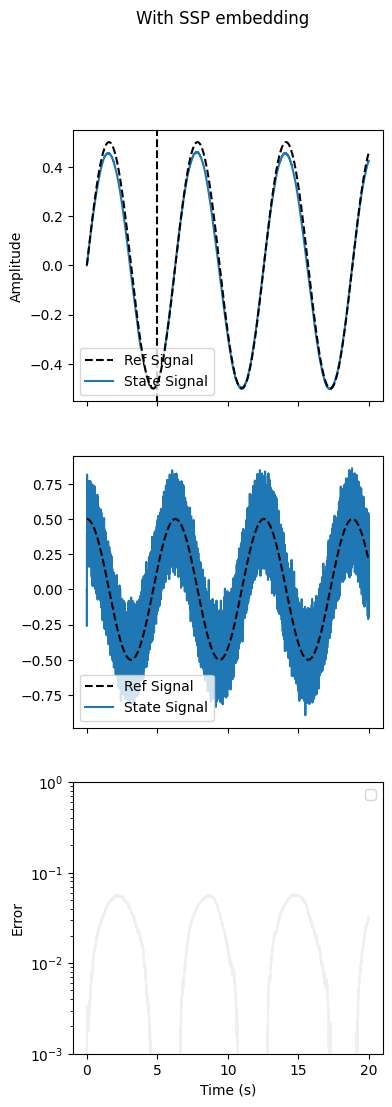

In [12]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

#Plot and evaluate
t = sim.trange()
ref_signal = sim.data[stim_probe]
out_signal = sim.data[sys_probe]
#e = mean_absolute_percentage_error(ref_signal,out_signal)/100
e = mean_squared_error(ref_signal[:,0],out_signal[:,0])
print(e)

if use_ssp == True:
    title = 'With SSP embedding'
else:
    title = 'No SSP embedding'

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(4.,12.),sharex=True)
ax1.plot(t, ref_signal[:,0], label='Ref Signal',zorder=10,color='k',linestyle='--')
ax1.plot(t, out_signal[:,0], label='State Signal')
ax1.legend(loc='lower left')
ax1.axvline(5.,color='k',linestyle='--')
ax3.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

ax2.plot(t, ref_signal[:,1], label='Ref Signal',zorder=10,color='k',linestyle='--')
ax2.plot(t, out_signal[:,1], label='State Signal')
ax2.legend(loc='lower left')

ax3.plot(t, ref_signal[:,0]-out_signal[:,0],color='dimgray',alpha=0.1)
ax3.axhline(e,color='k',linestyle='--')
ax3.set_yscale('log')
ax3.set_ylim(0.001,1.)
ax3.set_ylabel('Error')

fig.suptitle(title)
plt.legend()
plt.show()

rho actual:  0.0996399
(10000, 1000)


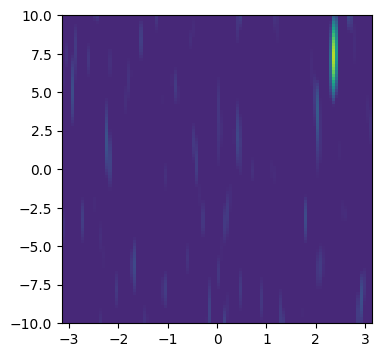

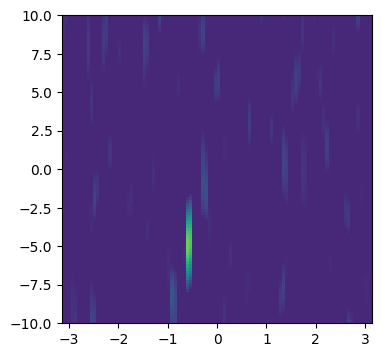

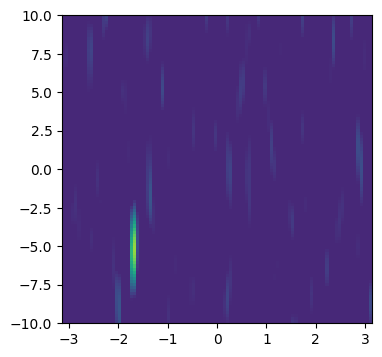

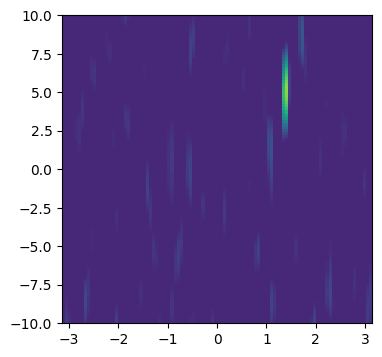

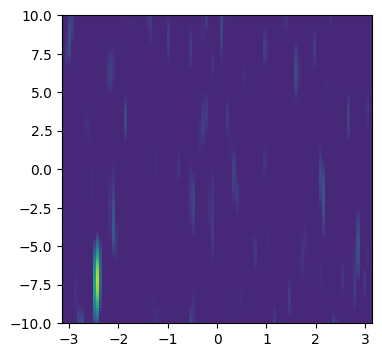

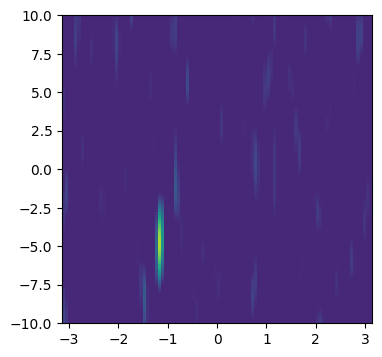

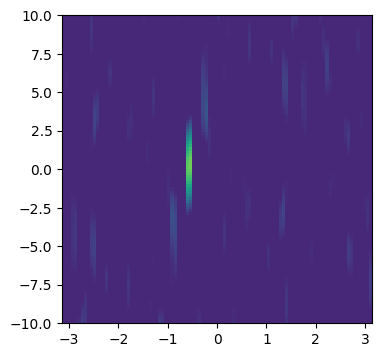

In [13]:
#import cupy as cp
import numpy as cp

n_eval_points = 100
meshes = np.meshgrid(*[np.linspace(b[0], b[1], n_eval_points) 
                        for b in domain_ranges_])
eval_xs = np.vstack([m.flatten() for m in meshes]).T

if use_ssp == True:
    eval_phis = cp.array(ssp_embedding.encode(eval_xs))
    _,A = nengo.utils.ensemble.tuning_curves( ens = adaptive, sim = sim, inputs = eval_phis )
else:
    _,A = nengo.utils.ensemble.tuning_curves( ens = adaptive, sim = sim, inputs = eval_xs )
    
    #def ReLU( scaled_encoders,bias,test_phis ):
#    return cp.clip( cp.dot(test_phis, scaled_encoders) + bias, a_min = 0., a_max = None )

#scaled_encoders = cp.array( sim.data[adaptive].scaled_encoders.T )
#bias = cp.array( sim.data[adaptive].bias.reshape(1,-1) )

#A = ReLU( scaled_encoders, bias, eval_phis )
print('rho actual: ', (A>0).mean())
print(A.shape)

for n in [55,89,144,233,377,610,987]:
    fig,ax = plt.subplots(1,1,figsize=(4.,4.))
    ax.imshow(A[:,n].reshape(n_eval_points,n_eval_points).T,
                  origin = 'lower',
                  extent = domain_ranges_.ravel(),
                  aspect = 'auto',
                  vmin = -0.13, vmax = 1.
             )
    plt.show()

# fig,ax = plt.subplots(1,1)
# ax.scatter(eval_xs[:,0],eval_xs[:,1],s=5)
# plt.show()
# 

## Graeme PID Adaptive

In [3]:

class pen:
    def __init__(self,dt,m,l,b):
        self.dt = dt
        self.m = m
        self.l = l
        self.b = b
        self.dt = dt
        self.g = 9.81
    def __call__(self,t, x):
        f_x = np.asarray([ x[1] , -self.m*self.g*self.l * np.sin(x[0]) - self.b*x[1] +x[2]])
        return x[0:2] + f_x * dt
#Sim parameters
num_neurons = 1000     
model = nengo.Network()
Tau_s = 0 

#Model parameters
m = 1
g = 9.8
l= 1
b=0.05
dt = 0.001

#Controller gains
kp  = 10
kd = 10
ki = 0

#Nengo model
with model:
    
    #Control function
    def PID(x):
        return kp * x[0] + kd * x[1]
    
    #Nodes and ensembles
    sys = nengo.Node(pen(dt,m,l,b),size_in = 3)
    stim = nengo.Node(lambda t: [0.5*np.sin(t),0.5*np.cos(t)]) #Stimulas
    
    err = nengo.Ensemble(num_neurons,2,radius = 2)
    con = nengo.Ensemble(num_neurons,1)
    integral = nengo.Ensemble(num_neurons,1)
    
    adaptive = nengo.Ensemble(num_neurons,2)

    #Connections
    nengo.Connection(err[0],integral,transform = 0.1)
    nengo.Connection(integral,integral)
    nengo.Connection(integral, con,transform = ki)
    nengo.Connection(sys,err,transform = -1,synapse  = Tau_s)
    nengo.Connection(stim,err,synapse  = Tau_s)
    nengo.Connection(sys,sys[0:2],synapse  = Tau_s)
    nengo.Connection(err,con,function = PID,synapse  = Tau_s)
    nengo.Connection(con, sys[2],transform = 10,synapse  = Tau_s)
    
    
    #Adaptive components
    nengo.Connection(sys,adaptive)
    
    u_adapt = nengo.Connection(adaptive,con, transform=np.zeros((1,2)), learning_rule_type=nengo.PES(learning_rate=2e-4))
    
    nengo.Connection(err,u_adapt.learning_rule,transform = -1,function = PID)
    

# Updated Code - Pendulum

## Random Neuron Basis

In [75]:
#System Parameters
m = 1
g = 9.8
l = 1
b = 0.05
dt = 0.001

#Controller Gains

lam = 0.7
ks = 20
weight_update_rate = 2e-4

#Model Parameters
num_neurons = 1000
basis_neurons = 100

In [76]:
class pen: #Without Disturbance
    def __init__(self,dt,m,l,b):
        self.dt = dt
        self.m = m
        self.l = l
        self.b = b
        self.dt = dt
        self.g = 9.81
    def __call__(self,t, x):
        # X[0:2] = [X, Xdot, U]
        f_x = np.asarray([ x[1] , -(self.g/(self.l*self.m)) * np.sin(x[0]) - (self.b/self.m)*x[1] + x[2]/self.m])
        return x[0:2] + f_x * dt

In [77]:
class pen: # With Disturbance
    def __init__(self,dt,m,l,b):
        self.dt = dt
        self.m = m
        self.l = l
        self.b = b
        self.dt = dt
        self.g = 9.81
    def __call__(self,t, x):
        # X[0:2] = [X, Xdot, U]
        if(t<10):
            dist = 0
        else:
            dist = (5/self.l)*np.sin(x[0])
        f_x = np.asarray([ x[1] , -(self.g/(self.l*self.m)) * np.sin(x[0]) - (self.b/self.m)*x[1] + x[2]/self.m + dist])
        return x[0:2] + f_x * dt

In [78]:
model = nengo.Network()
with model:
    def PD(e):
        return kp*e[0] + kp*e[1]
    def Sliding_Mode(e):
        s = e[1] + lam*e[0]
        g_x = m
        return (1/g_x)*(ks*s + lam*e[1])
    #Nodes
    sys = nengo.Node(pen(dt,m,l,b),size_in = 3)
    ref = nengo.Node( lambda t: [0.5*np.sin(t), 0.5*np.cos(t)]) #ref = [Xdes, Xdotdes]
    
    #Ensemble
    err = nengo.Ensemble(num_neurons,2) #err = [e, edot]
    adaptive_basis = nengo.Ensemble(basis_neurons,2) # Phi(x, xdot)
    
    #Connections
    reference_input = nengo.Connection(ref,err)
    feedback = nengo.Connection(sys, err, transform = -1)
    controller = nengo.Connection(err,sys[2],function = Sliding_Mode)
    state_connection = nengo.Connection(sys,sys[0:2],synapse = 0)
    adaptive_input = nengo.Connection(sys,adaptive_basis)
    
    #Probes
    state_probe = nengo.Probe(target = sys, attr = 'output')
    reference_probe = nengo.Probe(target = ref, attr = 'output')

    #Adaptive
    adaptive_weights = nengo.Connection(adaptive_basis,sys[2], transform=np.zeros((1,2)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode)
    
    err_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = probe_synapse)
    a_basis_probe = nengo.Probe(target = adaptive_basis, attr = 'decoded_output',synapse = probe_synapse)
    adaptive_signal_probe = nengo.Probe(target = adaptive_weights, attr = 'output',synapse = probe_synapse)
    sliding_signal_probe = nengo.Probe(target = controller, attr = 'output',synapse = probe_synapse)
    learning_signal_probe = nengo.Probe(target =learning_sig, attr = 'output',synapse = probe_synapse )

with nengo.Simulator(model) as sim:
    sim.run(20.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 1.0, 'Model: Pendulum\nController: Sliding Adaptive Random Basis')

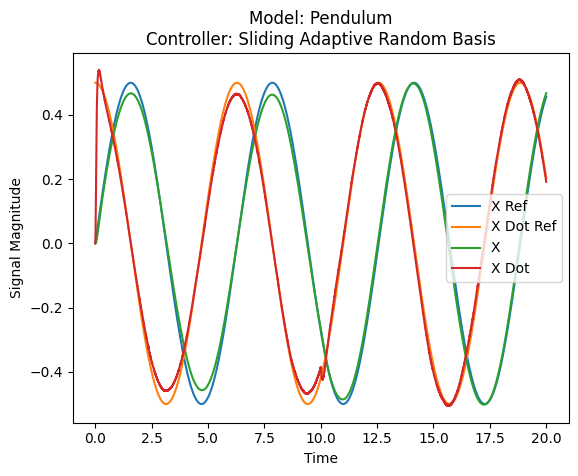

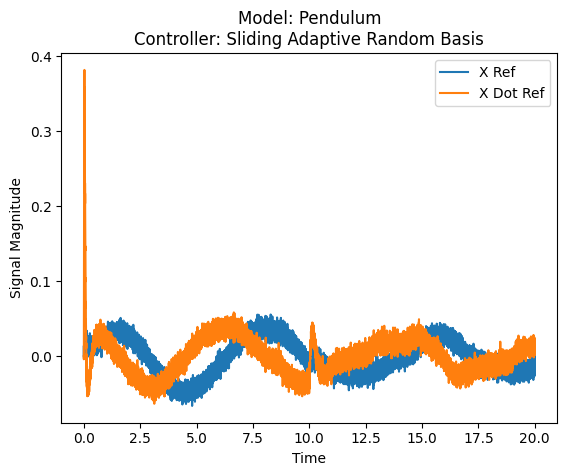

In [89]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
state_signal = sim.data[state_probe]
err_signal = sim.data[err_probe]
plt.figure()
plt.plot(t,ref_signal)
plt.plot(t,state_signal)
plt.legend(['X Ref','X Dot Ref','X','X Dot'])
plt.xlabel('Time')
plt.ylabel('Signal Magnitude')
plt.title('Model: Pendulum\nController: Sliding Adaptive Random Basis')
plt.figure()
plt.plot(t,err_signal)
plt.legend(['X Ref','X Dot Ref','X','X Dot'])
plt.xlabel('Time')
plt.ylabel('Signal Magnitude')
plt.title('Model: Pendulum\nController: Sliding Adaptive Random Basis')

(20000, 2)


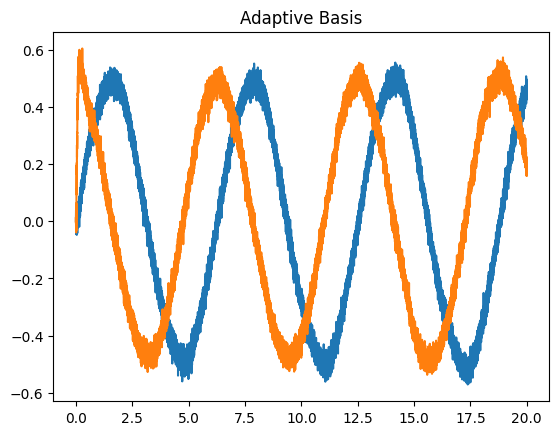

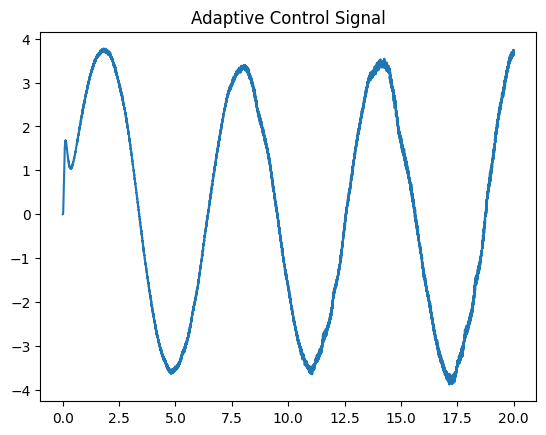

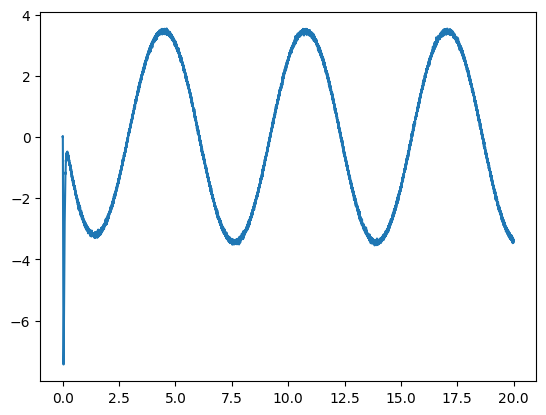

In [42]:
a_basis = sim.data[a_basis_probe]
adaptive_signal = sim.data[adaptive_signal_probe]
learning_signal - sim.data[learning_signal_probe]
print(a_basis.shape)
plt.figure()
plt.plot(t,a_basis[:,:]);
plt.title('Adaptive Basis')
plt.figure()
plt.plot(t,adaptive_signal);
plt.title('Adaptive Control Signal');
plt.figure()
plt.plot(t,learning_signal)

### Save Plots

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

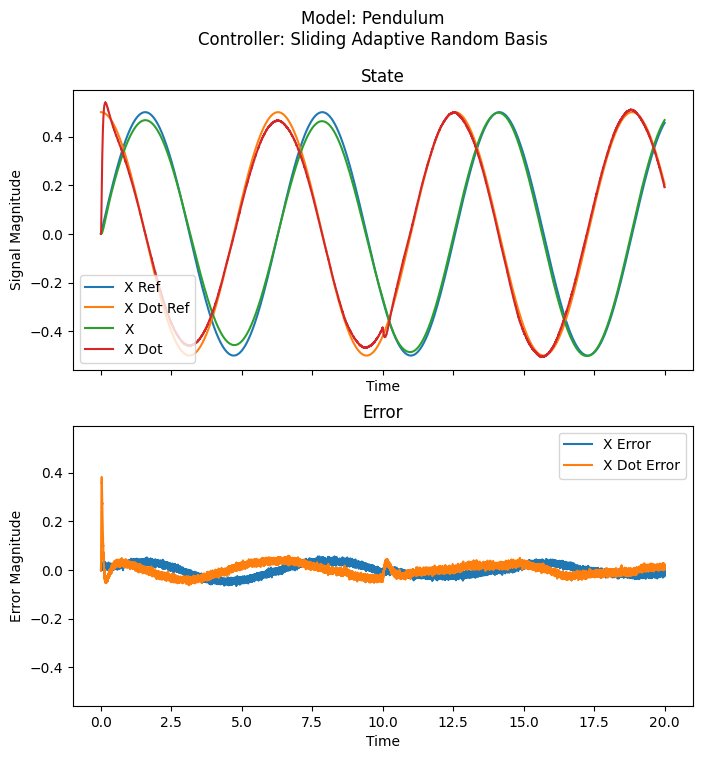

In [98]:

t = sim.trange()
ref_signal = sim.data[reference_probe]
state_signal = sim.data[state_probe]
err_signal = sim.data[err_probe]

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

fig.suptitle('Model: Pendulum\nController: Sliding Adaptive Random Basis')

axes[0].plot(t,ref_signal)
axes[0].plot(t,state_signal)
axes[0].legend(['X Ref','X Dot Ref','X','X Dot'])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Signal Magnitude')
axes[0].set_title('State')

axes[1].plot(t,err_signal)
axes[1].legend(['X Error','X Dot Error'])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Error Magnitude')
axes[1].set_title('Error')

output_directory = "subplots_output"
os.makedirs(output_directory, exist_ok=True)
output_file = os.path.join(output_directory, "Pendulum_Random_Basis.png")
plt.savefig(output_file)
plt.close

## Selected Neuron Basis

In [112]:
#System Parameters
m = 1
g = 9.8
l = 1
b = 0.05
dt = 0.001
joint_lim = [[-np.pi, np.pi],[-1,1]]
joint_mean = [0,0]
#Controller Gains
lam = 0.7
ks = 20
weight_update_rate = 2e-4

#Model Parameters
num_neurons = 1000
basis_neurons = 100


In [113]:
# Choose encoders

x_lim = [-0.5/np.pi,0.5/np.pi]
xdot_lim =  [-0.5/np.pi,0.5/np.pi]

e_2d = np.array([np.linspace(x_lim[0],x_lim[1],basis_neurons),np.linspace(x_lim[0],x_lim[1],basis_neurons)])
e_3d = np.zeros((3,basis_neurons))
for i in range(basis_neurons):
    x_norm = np.linalg.norm(e_2d[:,i])
    z = np.append(2*e_2d[:,i]/(1+x_norm**2),(1-x_norm**2)/(1+x_norm**2))
    e_3d[:,i] = z
e_3d = np.transpose(e_3d)

In [114]:
class pen: # Without Disturbance
    def __init__(self,dt,m,l,b):
        self.dt = dt
        self.m = m
        self.l = l
        self.b = b
        self.dt = dt
        self.g = 9.81
    def __call__(self,t, x):
        # X[0:2] = [X, Xdot, U]
        f_x = np.asarray([ x[1] , -(self.g/(self.l*self.m)) * np.sin(x[0]) - (self.b/self.m)*x[1] + x[2]/self.m])
        return x[0:2] + f_x * dt

In [115]:
class pen: # With Disturbance
    def __init__(self,dt,m,l,b):
        self.dt = dt
        self.m = m
        self.l = l
        self.b = b
        self.dt = dt
        self.g = 9.81
    def __call__(self,t, x):
        # X[0:2] = [X, Xdot, U]
        if(t<10):
            dist = 0
        else:
            dist = (5/self.l)*np.sin(x[0])
        f_x = np.asarray([ x[1] , -(self.g/(self.l*self.m)) * np.sin(x[0]) - (self.b/self.m)*x[1] + x[2]/self.m + dist])
        return x[0:2] + f_x * dt

In [116]:
model = nengo.Network()
with model:
    def PD(e):
        return kp*e[0] + kp*e[1]
    def Sliding_Mode(e):
        s = e[1] + lam*e[0]
        g_x = m
        return (1/g_x)*(ks*s + lam*e[1])
    def project(x): # Stereographic projection
        x[0] = (x[0] - joint_mean[0])/joint_lim[0][0]
        x[1] = (x[1] - joint_mean[1])/joint_lim[1][0]
        x_norm = np.linalg.norm(x)
        z = np.append(2*x/(1+x_norm**2),(1-x_norm**2)/(1+x_norm**2))
        return z
    
    #Nodes
    sys = nengo.Node(pen(dt,m,l,b),size_in = 3)
    ref = nengo.Node( lambda t: [0.5*np.sin(t), 0.5*np.cos(t)]) #ref = [Xdes, Xdotdes]
    
    #Ensemble
    err = nengo.Ensemble(num_neurons,2) #err = [e, edot]
    adaptive_basis = nengo.Ensemble(basis_neurons,3,encoders = e_3d) # Phi(x, xdot)
    
    #Connections
    reference_input = nengo.Connection(ref,err)
    feedback = nengo.Connection(sys, err, transform = -1)
    controller = nengo.Connection(err,sys[2],function = Sliding_Mode)
    state_connection = nengo.Connection(sys,sys[0:2],synapse = 0)
    adaptive_input = nengo.Connection(sys,adaptive_basis, function = project)
    
    #Probes
    state_probe = nengo.Probe(target = sys, attr = 'output')
    reference_probe = nengo.Probe(target = ref, attr = 'output')
    err_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = probe_synapse)

    #Adaptive
    adaptive_weights = nengo.Connection(adaptive_basis,sys[2], transform=np.zeros((1,3)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    learing_rule = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode)

with nengo.Simulator(model) as sim:
    sim.run(20.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

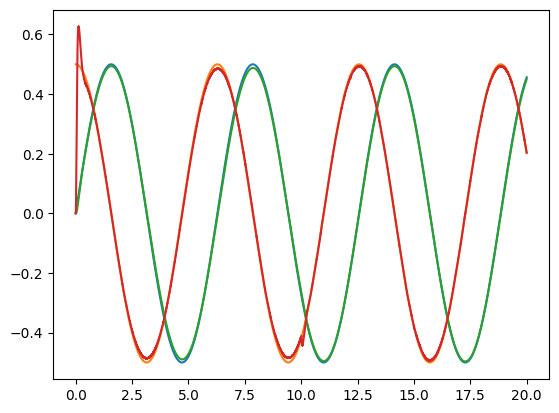

In [117]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
state_signal = sim.data[state_probe]
plt.plot(t,ref_signal)
plt.plot(t,state_signal)

### Save Plots

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

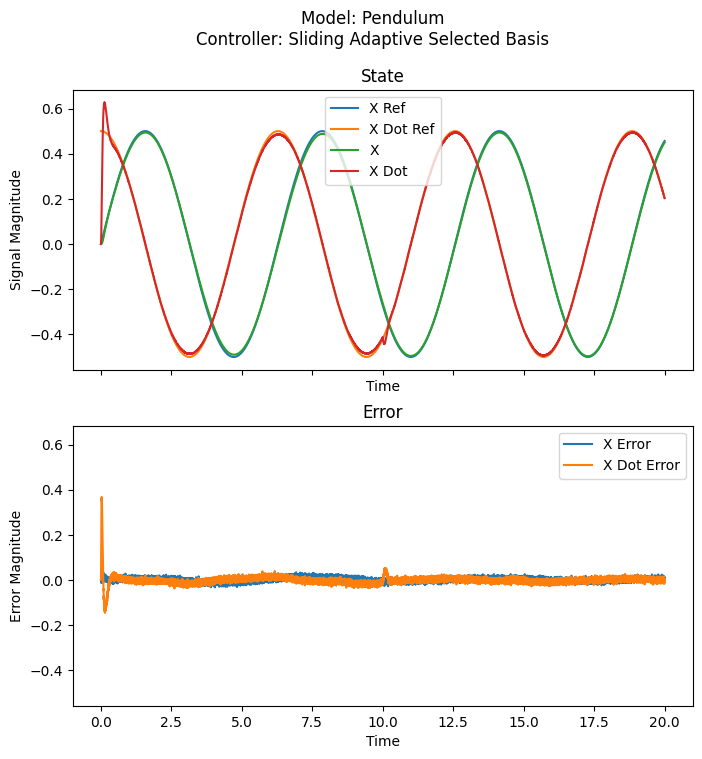

In [118]:

t = sim.trange()
ref_signal = sim.data[reference_probe]
state_signal = sim.data[state_probe]
err_signal = sim.data[err_probe]

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

fig.suptitle('Model: Pendulum\nController: Sliding Adaptive Selected Basis')

axes[0].plot(t,ref_signal)
axes[0].plot(t,state_signal)
axes[0].legend(['X Ref','X Dot Ref','X','X Dot'])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Signal Magnitude')
axes[0].set_title('State')

axes[1].plot(t,err_signal)
axes[1].legend(['X Error','X Dot Error'])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Error Magnitude')
axes[1].set_title('Error')

output_directory = "subplots_output"
os.makedirs(output_directory, exist_ok=True)
output_file = os.path.join(output_directory, "Pendulum_Selected_Basis.png")
plt.savefig(output_file)
plt.close

## SSP Basis Functions

In [219]:
#Neuron Parameters
num_neurons = 1000
model = nengo.Network()
Tau_s = 0 

#System Parameters
m = 1
g = 9.8
l = 1
b = 0.05
dt = 0.001

#Controller Gains
lam = 0.7
ks = 20
# 
probe_synapse = 0.01
domain_ranges_ = np.array([[-np.pi,np.pi],[-10.,10.]])
adaptive_controller = True
use_ssp = True
ssp_dim = 512
rho_specified = 0.421
#encoders_type = 'random'
encoders_type = 'place-cells'
psd_sampling = 'gaussian'
length_scale = np.asarray([[0.82,5.31]])
#neuron_type = nengo.SpikingRectifiedLinear()
neuron_type = nengo.LIF()
learning_rate=0.0011#2e-4

In [220]:
class pen: # Without Disturbance
    def __init__(self,dt,m,l,b):
        self.dt = dt
        self.m = m
        self.l = l
        self.b = b
        self.dt = dt
        self.g = 9.81
    def __call__(self,t, x):
        # X[0:2] = [X, Xdot, U]
        f_x = np.asarray([ x[1] , -(self.g/(self.l*self.m)) * np.sin(x[0]) - (self.b/self.m)*x[1] + x[2]/self.m])
        return x[0:2] + f_x * dt

In [221]:
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)
    
    
def encode_rff( x, n_features, length_scale, kernel = 'gaussian', coefficient = 1., n_functions = 1):
    # print(type(x))
    
    # dimensionality of feature space
    x_dim = x.shape[-1]
    omega_shape = (n_functions, n_features, x_dim)
    
    if kernel == 'gaussian':
        omega = np.random.normal( size = omega_shape )
        
    # Scale omegas by lengthscale
    omega = omega / length_scale

    phi = np.random.uniform( low = 0., high = (2 * np.pi), size = (n_functions, n_features, 1) )
    
    features = np.cos( np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / n_features) ** 0.5 * features * coefficient

    return features[0,:,:].T

In [224]:
model = nengo.Network()
with model:
    def PD(e):
        return kp*e[0] + kp*e[1]
    def Sliding_Mode(e):
        s = e[1] + lam*e[0]
        g_x = m
        return (1/g_x)*(ks*s + lam*e[1])
    #Nodes
    sys = nengo.Node(pen(dt,m,l,b),size_in = 3)
    ref = nengo.Node( lambda t: [0.5*np.sin(t), 0.5*np.cos(t)]) #ref = [Xdes, Xdotdes]
    
    #Ensemble
    err = nengo.Ensemble(num_neurons,2) #err = [e, edot]
    
    #Connections
    reference_input = nengo.Connection(ref,err)
    feedback = nengo.Connection(sys, err, transform = -1)
    controller = nengo.Connection(err,sys[2],function = Sliding_Mode)
    state_connection = nengo.Connection(sys,sys[0:2],synapse = 0)
    
    
    #Adaptive Controller Block
    print('embedding data into ssp space')
    ssp_embedding = RandomSSPSpace( domain_dim = 2, 
                                       ssp_dim = ssp_dim, 
                                       length_scale = length_scale, 
                                       psd_sampling = psd_sampling )
    xi = - sparsity_to_x_intercept( d = ssp_dim, p = rho_specified )
    print('xi: ', xi)
    
    def encode_ssp(t,x):
        #print(x)
        return ssp_embedding.encode(x).flatten()

    if encoders_type == 'random':
        encoders = nengo.dists.UniformHypersphere(surface=True).sample(num_neurons, ssp_dim)
    
    elif encoders_type == 'place-cells':
        e_xs = np.random.uniform(low=domain_ranges_[:,0],high=domain_ranges_[:,1],size=(num_neurons,ssp_embedding.domain_dim))
        encoders = ssp_embedding.encode(e_xs)

    # create ensemble; random encoders for now
    adaptive = nengo.Ensemble(n_neurons = num_neurons, 
                              dimensions = ssp_embedding.ssp_dim,
                              gain = 100*np.ones(num_neurons),
                              bias = np.zeros(num_neurons) + xi,
                              neuron_type = neuron_type,
                              encoders = encoders,
                              normalize_encoders = False,
                             )
    ssp_node = nengo.Node(encode_ssp,size_in=2)
    nengo.Connection(sys,ssp_node)
    nengo.Connection(ssp_node,adaptive)

#    a = nengo.Connection(adaptive[0:2],sys[2],transform = np.zeros((1,2)),learning_rule_type=nengo.PES(learning_rate=learning_rate))
    a = nengo.Connection(adaptive,sys[2],transform = np.zeros((1,adaptive.dimensions)),learning_rule_type=nengo.PES(learning_rate=learning_rate))
    learning_sig = nengo.Connection(err,a.learning_rule,function = Sliding_Mode,transform = -1) 
    
    #Probes
    state_probe = nengo.Probe(target = sys, attr = 'output',synapse = probe_synapse)
    reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = probe_synapse)
    err_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = probe_synapse)
    a_basis_probe = nengo.Probe(target = adaptive, attr = 'decoded_output',synapse = probe_synapse)
    adaptive_signal_probe = nengo.Probe(target = a, attr = 'output',synapse = probe_synapse)
    sliding_signal_probe = nengo.Probe(target = controller, attr = 'output',synapse = probe_synapse)
    learning_signal_probe = nengo.Probe(target =learning_sig, attr = 'output',synapse = probe_synapse )
with nengo.Simulator(model) as sim:
    sim.run(20.0)

embedding data into ssp space
xi:  -0.008822244457604846


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

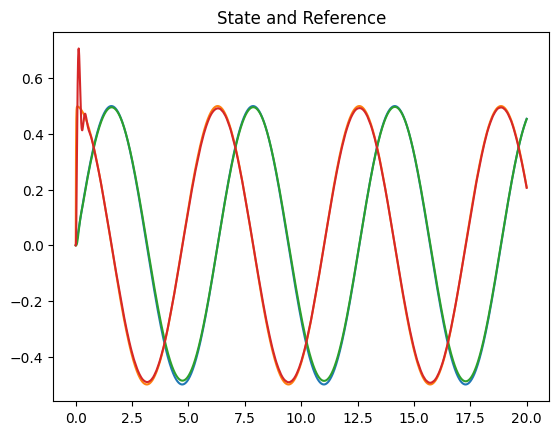

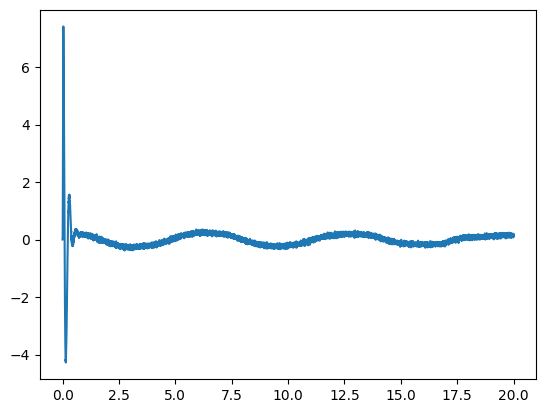

In [225]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
state_signal = sim.data[state_probe]
sliding_sigal = sim.data[sliding_signal_probe]
plt.figure()
plt.plot(t,ref_signal)
plt.plot(t,state_signal)
plt.title('State and Reference')

plt.figure()
plt.plot(t,sliding_sigal)

(20000, 512)


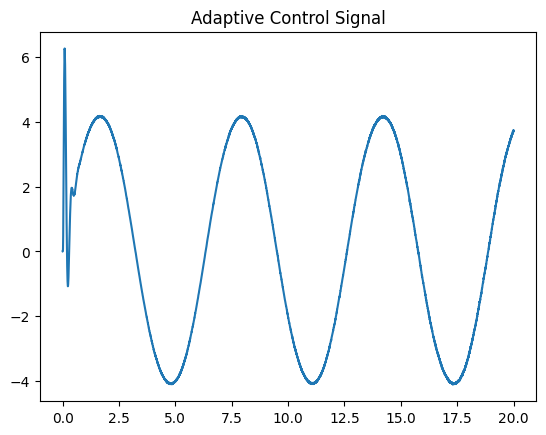

In [226]:
a_basis = sim.data[a_basis_probe]
adaptive_signal = sim.data[adaptive_signal_probe]
print(a_basis.shape)
#plt.figure()
#plt.plot(t,a_basis[:,:]);
#plt.title('Adaptive Basis')
plt.figure()
plt.plot(t,adaptive_signal);
plt.title('Adaptive Control Signal');

(20000, 2)


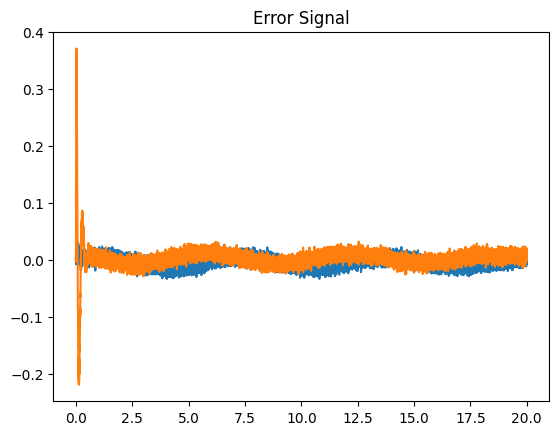

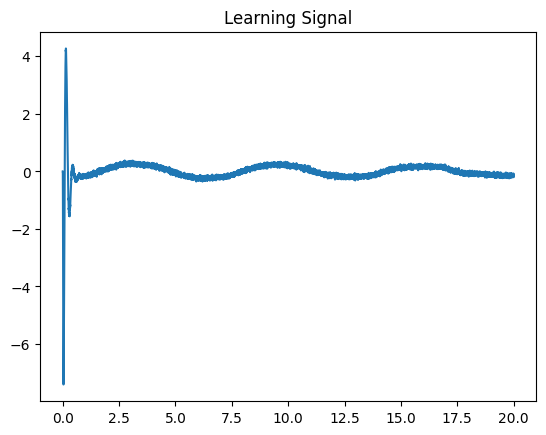

In [227]:
plt.figure()
err_signal = sim.data[err_probe]
print(err_signal.shape)
plt.title('Error Signal')
plt.plot(t,err_signal)
plt.figure()
plt.title('Learning Signal')
learning_signal = sim.data[learning_signal_probe]
plt.plot(t,learning_signal)

### Save Plots

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

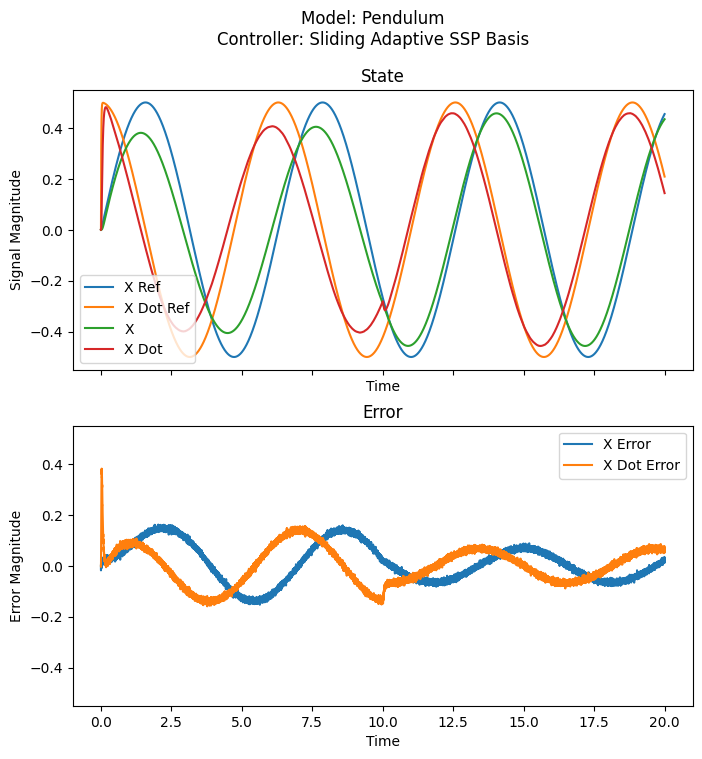

In [109]:

t = sim.trange()
ref_signal = sim.data[reference_probe]
state_signal = sim.data[state_probe]
err_signal = sim.data[err_probe]

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

fig.suptitle('Model: Pendulum\nController: Sliding Adaptive SSP Basis')

axes[0].plot(t,ref_signal)
axes[0].plot(t,state_signal)
axes[0].legend(['X Ref','X Dot Ref','X','X Dot'])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Signal Magnitude')
axes[0].set_title('State')

axes[1].plot(t,err_signal)
axes[1].legend(['X Error','X Dot Error'])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Error Magnitude')
axes[1].set_title('Error')

output_directory = "subplots_output"
os.makedirs(output_directory, exist_ok=True)
output_file = os.path.join(output_directory, "Pendulum_SSP_Basis.png")
plt.savefig(output_file)
plt.close

# Updated Code - Arm

## Numerical Implementation of Arm

[ 0.         -0.09827928 -0.14965327 -0.11723856] [0.         0.01847113 0.10426573 0.1988664 ]
[ 0.         -0.07411737 -0.0529899  -0.03854811] [0.         0.06713133 0.164874   0.26382568]
[ 0.         -0.03167438  0.00832906 -0.01262032] [0.         0.09485111 0.18650113 0.28428213]
[ 0.         -0.00039127  0.02448816 -0.00401827] [0.         0.09999923 0.19685487 0.29270571]
[ 0.          0.01474285  0.02225712 -0.00119803] [0.         0.09890727 0.19862455 0.29583492]
[ 0.          0.02059118  0.01413062 -0.00027615] [0.         0.09785706 0.19764814 0.29660493]
[0.00000000e+00 2.05010528e-02 5.28259435e-03 2.35753121e-06] [0.         0.09787598 0.19671119 0.29657168]
[0.00000000e+00 1.80789590e-02 2.70136014e-04 5.19996173e-05] [0.         0.09835218 0.19675363 0.29675339]
[ 0.00000000e+00  1.64709205e-02 -4.42503647e-04  4.60485725e-05] [0.         0.09863422 0.19719352 0.29719233]
[0.00000000e+00 1.62826837e-02 9.47649624e-04 4.36505179e-05] [0.         0.09866547 0.19748265 

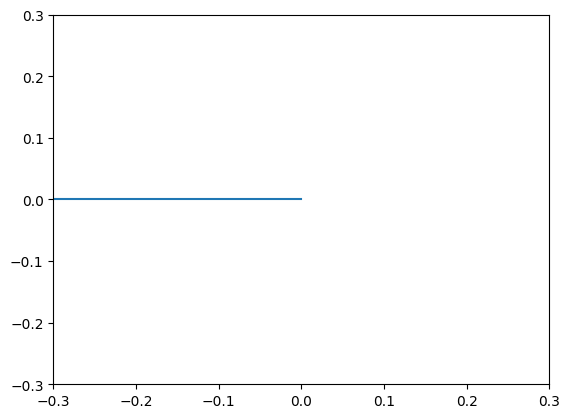

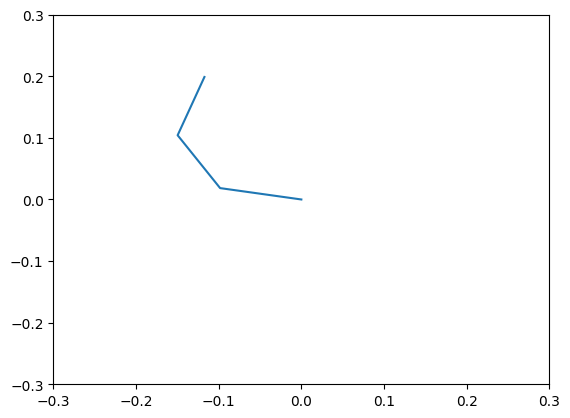

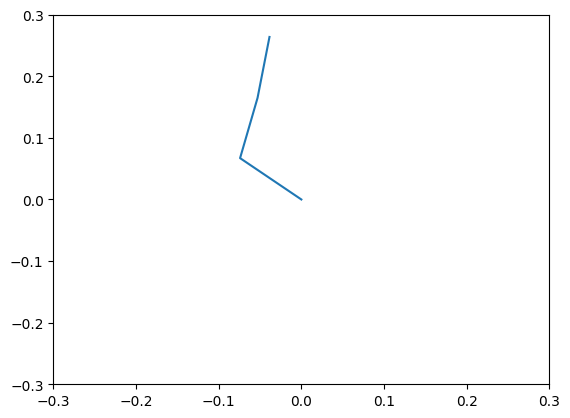

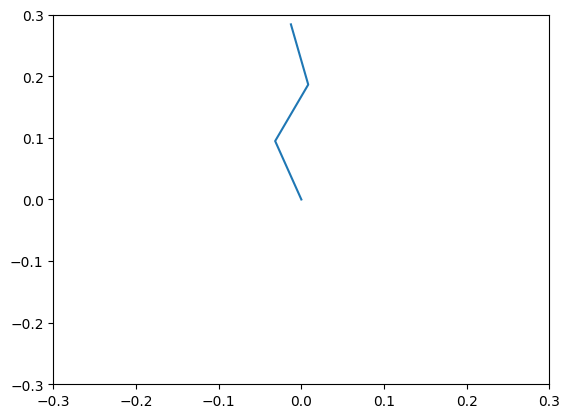

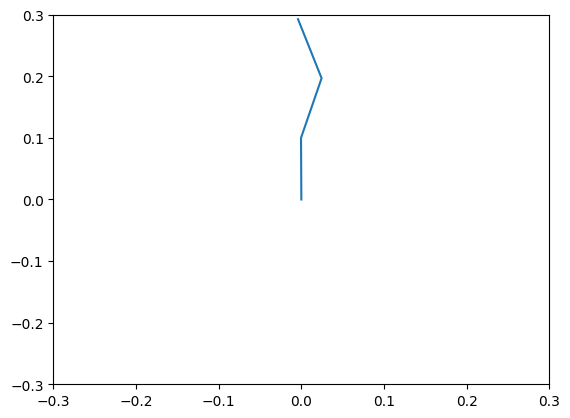

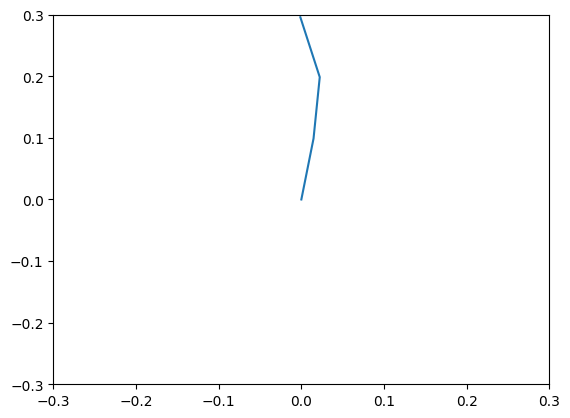

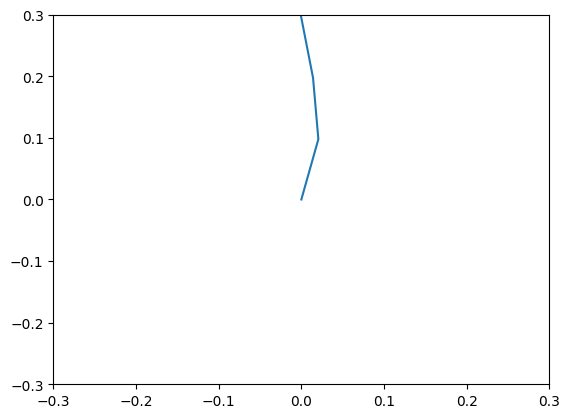

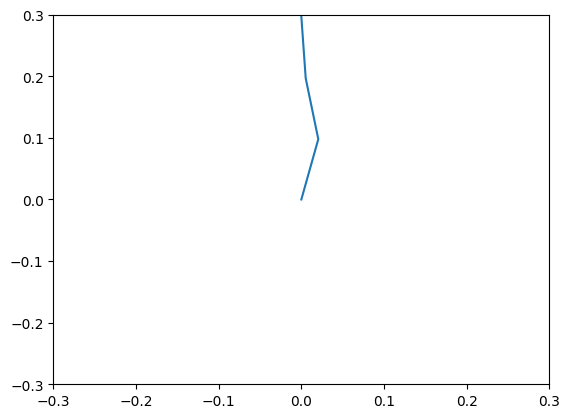

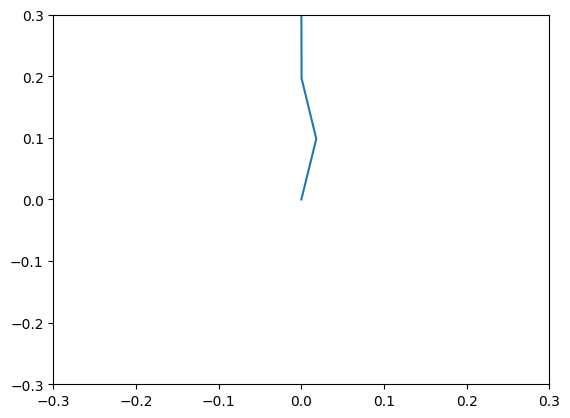

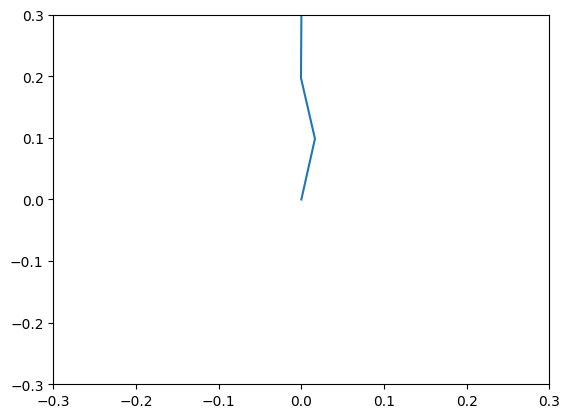

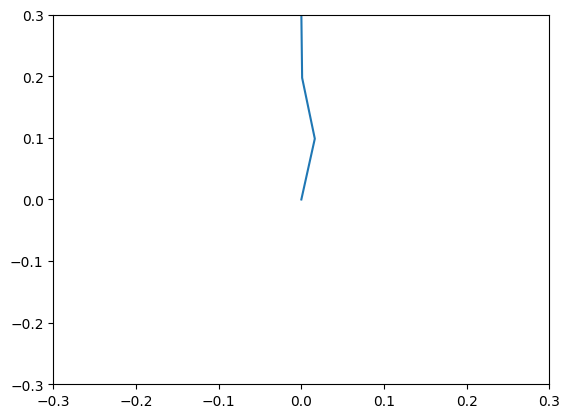

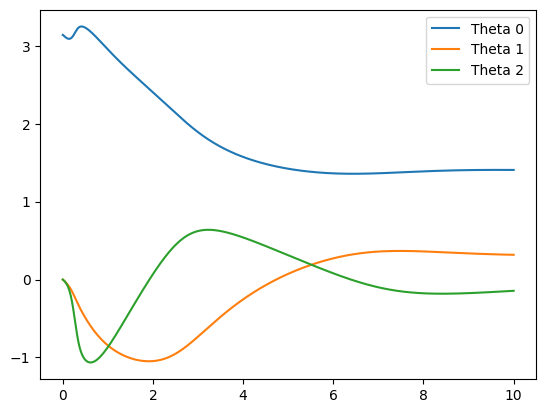

In [47]:
#Works
class arm:
    def __init__(self, l, m, dt):
        self.l0 = l[0]
        self.l1 = l[1]
        self.l2 = l[2]
        
        self.m0 = m[0]
        self.m1 = m[1]
        self.m2 = m[2]
        
        #self.theta = theta
        #self.thetaDot = thetaDot
        self.dt = dt
    def dynamics(self,theta,U):
        theta_dot = np.zeros((3,2))
        JofXwrtQ3 = vJq(theta[:,0],[self.l0,self.l1,self.l2]);
        JofXwrtQ2 = vJq(theta[:,0],[self.l0,self.l1, 0]);
        JofXwrtQ1 = vJq(theta[:,0],[self.l0, 0, 0]);

        Fg = np.matrix([0, -9.8, 0]).T;
        Fqg1 = JofXwrtQ1.T * Fg * self.m0;
        Fqg2 = JofXwrtQ2.T * Fg * self.m1;
        Fqg3 = JofXwrtQ3.T * Fg * self.m2;
        Fqg = Fqg1+Fqg2+Fqg3;
        
        #Find net torque
        Fqnet = Fqg + np.matrix(U).T;
        
        #Get accerlation and velocity
        # Need joint limit check 
        theta_dot[0,1] = theta[0,1] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2)
        theta_dot[1,1] = theta[1,1] + self.dt*Fqnet.item(1)/(self.m1+self.m2)
        theta_dot[2,1] = theta[2,1] + self.dt*Fqnet.item(2)/(self.m2)

        theta_dot[0,0] = theta[0,0] + dt * theta[0,1]
        theta_dot[1,0] = theta[1,0] + dt * theta[1,1]
        theta_dot[2,0] = theta[2,0] + dt * theta[2,1]
        
        return theta_dot

def aTb(theta, l):
    T = np.matrix(
        ([np.cos(theta),-np.sin(theta),l*np.cos(theta)],
        [np.sin(theta),np.cos(theta),l*np.sin(theta)],
        [0,0,1]));
    return T
    
def vJq(Theta,L):
    J = np.matrix(
            ([(-L[0]*np.sin(Theta[0])-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2]))],
            [(L[0]*np.cos(Theta[0])+L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[2]*np.cos(Theta[0]+Theta[1]+Theta[2]))],
            [0, 0, 0]))
    return J

def qTx(theta,l):
    p0 = np.array([0,0])
    p1 = p0 + np.array([l[0]*np.cos(theta[0]),l[0]*np.sin(theta[0])])
    p2 = p1 + np.array([l[0]*np.cos(theta[0]+theta[1]),l[0]*np.sin(theta[0]+theta[1])])
    p3 = p2 + np.array([l[0]*np.cos(theta[0]+theta[1]+theta[2]),l[0]*np.sin(theta[0]+theta[1]+theta[2])])

    P = np.vstack((p0,p1))
    P = np.vstack((P,p2))
    P = np.vstack((P,p3))

    return P

def Sliding_Mode(e,ks):
    s = e[0,:] + lam*e[1,:]
    g_x = m
    return (1/9.8)*(ks*s + lam*e[1,:])

#Sim parameters
T = 10
dt = 0.001
K = int(T/dt)
time = np.linspace(0,T,K)

#Sys parameters
l = [0.1,0.1,0.1]
m = [0.1,0.1,0.1]
sys = arm(l,m,dt)

# Control parameters
theta = np.zeros((3,2,K))
theta[:,0,0] = [np.pi,0,0]
theta_dot_des = 0

P_des = [0,0.3]
P_dot_des = [0,0]
lam = 0.9
ks = 100*100

error_data = np.zeros((4,K))

for k in range(1,K):
    
    JofX = vJq(theta[:,0,k-1],l)
    P = qTx(theta[:,0,k-1],l)
    P_dot = np.array(np.matmul(JofX,theta[:,1,k-1]))
    
    error_X = P_des - P[3,:]
    error_Xdot = P_dot_des - P_dot[0,0:2]
    #e = [[P_des - P[3,:]],[P_dot_des - P_dot[0,0:2]]]

    e = np.vstack((P_des - P[3,:],P_dot_des - P_dot[0,0:2]))
    error_data[:,k] = e.flatten()
    
    u1 =  100 * error_X + 10 *error_Xdot# + 50 * error_xdot
    u = Sliding_Mode(e,ks)
    
    u = np.append(u,0)

    u_q = np.matmul(JofX.T,u.T) - 0.1*theta[:,1,k-1] #Second term is second controller to prevent joint vibration
    Fg = np.matrix([0, -9.8, 0]).T;

    #u_q = np.matmul(JofX.T,u.T)# + 0.1*JofX.T*Fg
    theta[:,:,k] = sys.dynamics(theta[:,:,k-1],u_q)
   
    # For plotting
    if(k == 1):
        plt.figure()
        plt.plot(P[:,0],P[:,1])
        plt.axis([-0.3, 0.3, -0.3, 0.3])
        
    if (k+1)%int(K/10) == 0:
        plt.figure()
        plt.plot(P[:,0],P[:,1])
        plt.axis([-0.3, 0.3, -0.3, 0.3])
        print(P[:,0],P[:,1])
plt.figure()
plt.plot(time,np.transpose(theta[:,0,:]))
plt.legend(['Theta 0','Theta 1','Theta 2'])




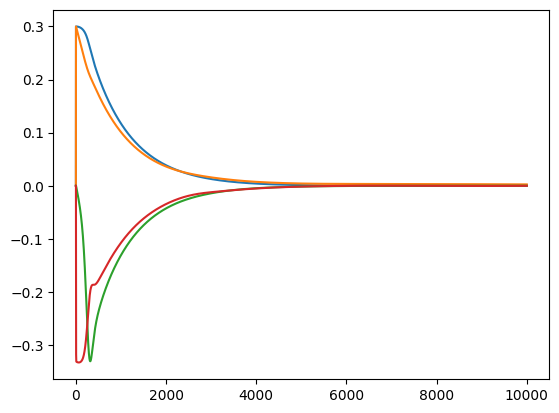

In [48]:
plt.plot(error_data.T)

## Nengo - Sliding Only

In [435]:
#Model Parameters
num_neurons = 1000
con_rad = 3
scale_factor = 100/con_rad
seed = 11
sim_time = 20
#Sys parameters
l = [0.1,0.1,0.1]
m = [0.1,0.1,0.1]

# Control parameters
lam = 0.5
ks = 30


In [436]:
class arm:
    def __init__(self, l, m, dt):
        self.l0 = l[0]
        self.l1 = l[1]
        self.l2 = l[2]
        
        self.m0 = m[0]
        self.m1 = m[1]
        self.m2 = m[2]
        
        #self.theta = theta
        #self.thetaDot = thetaDot
        self.dt = dt
    def __call__(self,t,inputs): #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
        theta_dot = np.zeros(6)
        JofXwrtQ3 = vJq(inputs[0:3],[self.l0,self.l1,self.l2]);
        JofXwrtQ2 = vJq(inputs[0:3],[self.l0,self.l1, 0]);
        JofXwrtQ1 = vJq(inputs[0:3],[self.l0, 0, 0]);

        Fg = np.matrix([0, -9.8, 0]).T;
        Fqg1 = JofXwrtQ1.T * Fg * self.m0;
        Fqg2 = JofXwrtQ2.T * Fg * self.m1;
        Fqg3 = JofXwrtQ3.T * Fg * self.m2;
        Fqg = Fqg1+Fqg2+Fqg3;
        
        #Find net torque
        Fqnet = Fqg + np.matrix(inputs[6:9]).T;
        
        #Get accerlation and velocity
        # Need joint limit check 
        theta_dot[3] = inputs[3] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2)
        theta_dot[4] = inputs[4] + self.dt*Fqnet.item(1)/(self.m1+self.m2)
        theta_dot[5] = inputs[5] + self.dt*Fqnet.item(2)/(self.m2)

        theta_dot[0] = inputs[0] + dt * inputs[3]
        theta_dot[1] = inputs[1] + dt * inputs[4]
        theta_dot[2] = inputs[2] + dt * inputs[5]
        
        return np.array(theta_dot)
def vJq(Theta,L):
    J = np.matrix(
            ([(-L[0]*np.sin(Theta[0])-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2]))],
            [(L[0]*np.cos(Theta[0])+L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[2]*np.cos(Theta[0]+Theta[1]+Theta[2]))],
            [0, 0, 0]))
    return J

In [437]:
seed = 11
model = nengo.Network(seed = seed)
with model:
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/scale_factor)*(1/g_x)*(ks*s + lam*e[2:4]) #u
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [u,theta]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return scale_factor*u_q #uq = [uq1,uq2,uq3]
        

    sys = nengo.Node(arm(l,m,dt),size_in = 9)
    
    #ref = nengo.Node( lambda t: [0.1*np.sin(t),0.1*np.cos(t),0.1*np.cos(t),-0.1*np.sin(t)]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 10 else [0.3,0,0,0]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    P_record = nengo.Ensemble(num_neurons,4,neuron_type = nengo.Direct()) #P_record = [Px,Py,Px_dot,Py_dot]
    #Ensemble
    err = nengo.Ensemble(num_neurons,4,radius = 0.4)#,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
    #con = nengo.Ensemble(num_neurons,5,radius = 10, neuron_type = nengo.Direct()) #con = [ux,uy,theta1,theta2,theta3]
    con = nengo.Ensemble(num_neurons,5,radius = con_rad, neuron_type = nengo.LIF())
    
    #Connections
    reference_input = nengo.Connection(ref,err, synapse = connnection_synapse)
    feedback = nengo.Connection(sys, err, function = qTx,transform = -1 , synapse = connnection_synapse) 
    state_recorder = nengo.Connection(sys, P_record, function = qTx , synapse = connnection_synapse)
    controller = nengo.Connection(err,con[0:2],function = Sliding_Mode, synapse = connnection_synapse)
    theta_controller = nengo.Connection(sys[0:3],con[2:5], synapse = connnection_synapse)
    state_connection = nengo.Connection(sys,sys[0:6],synapse = 0)
    control_input = nengo.Connection(con,sys[6:9],function = JofQ, synapse = connnection_synapse)
    
    #Optional, provides more stable joints
    #theta_control = nengo.Connection(sys[3:6],sys[6:9], transform = -0.1)
    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.1)
    reference_probe = nengo.Probe(target = ref, attr = 'output')
    state_probe = nengo.Probe(target = P_record, attr = 'decoded_output', synapse = 0.1)
    joint_probe = nengo.Probe(target = sys, attr = 'output')
    con_probe = nengo.Probe(target = con, attr = 'decoded_output', synapse = 0.1)
    control_input = nengo.Probe(target = control_input, attr = 'output', synapse = 0.1 )

with nengo.Simulator(model) as sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

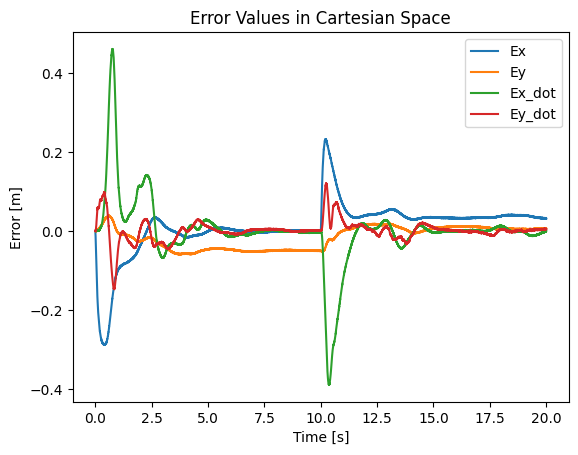

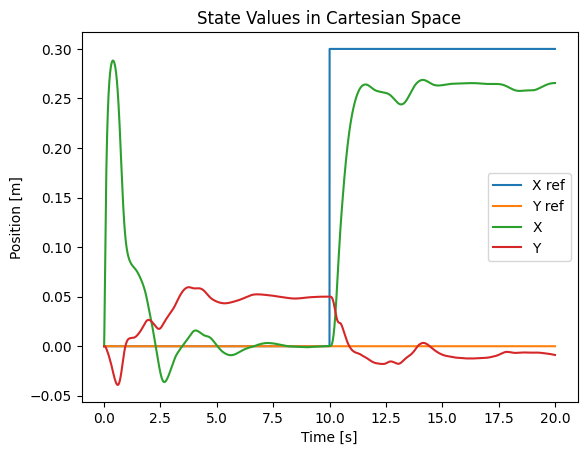

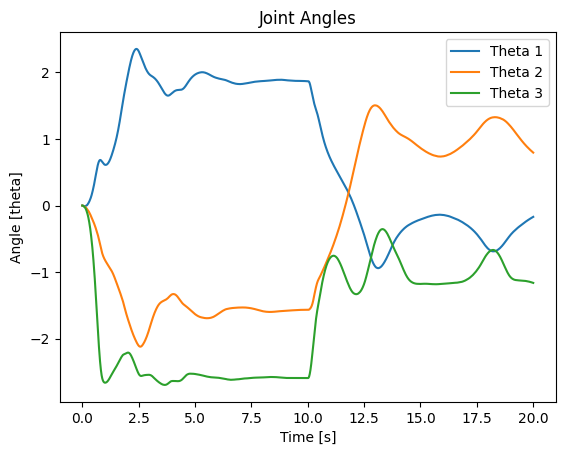

In [438]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Theta 3'])

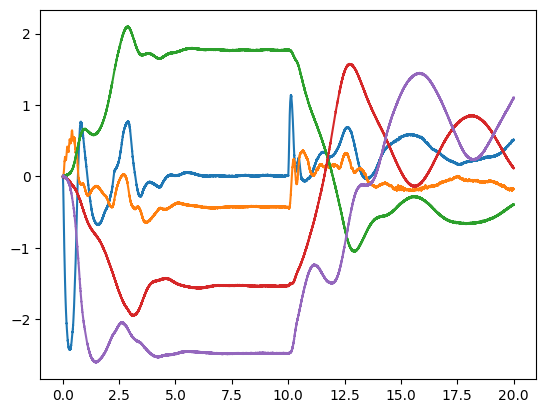

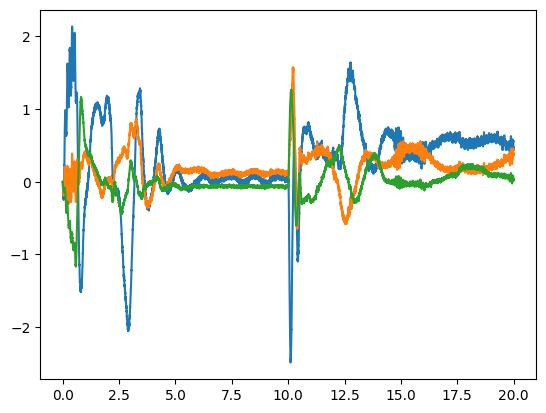

In [434]:
plt.figure()
con_signal = sim.data[con_probe]
plt.plot(t,con_signal[:,0:5])

plt.figure()
con_input_signal = sim.data[control_input]
plt.plot(t,con_input_signal)

In [442]:
# Access and print ensemble parameters
print("Number of Neurons:", con.n_neurons)
print("Dimensions:", con.dimensions)
print("Radius:", con.radius)
print("Neuron Type:", con.neuron_type)
print("Encoders:\n", con.encoders)
print("Gain:\n", con.gain)
print("Bias:\n", con.bias)
print("Max Rates:\n", con.max_rates)
print("Intercepts:\n", con.intercepts)

with nengo.Simulator(model) as sim:
    # After building the simulator, you can access parameters
    print("Encoders:\n", sim.data[con].encoders)
    print("Gain:\n", sim.data[con].gain)
    print("Bias:\n", sim.data[con].bias)

Number of Neurons: 1000
Dimensions: 5
Radius: 3
Neuron Type: LIF()
Encoders:
 ScatteredHypersphere(surface=True)
Gain:
 None
Bias:
 None
Max Rates:
 Uniform(low=200, high=400)
Intercepts:
 Uniform(low=-1.0, high=0.9)


## Nengo Adaptive - Random V2

In [82]:
#Model Parameters
num_neurons = 10000
basis_neurons = 1000
con_rad = 3
scale_factor = 100/con_rad
seed = 11
sim_time = 20
connection_synapse = 0.001
#Sys parameters
l = [0.1,0.1,0.1]
m = [0.1,0.1,0.1]

# Control parameters
lam = 0.5
ks = 30
dt = 0.00001
weight_update_rate = 2e-4

In [83]:
class arm:
    def __init__(self, l, m, dt):
        self.l0 = l[0]
        self.l1 = l[1]
        self.l2 = l[2]
        
        self.m0 = m[0]
        self.m1 = m[1]
        self.m2 = m[2]
        
        #self.theta = theta
        #self.thetaDot = thetaDot
        self.dt = dt
    def __call__(self,t,inputs): #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
        theta_dot = np.zeros(6)
        JofXwrtQ3 = vJq(inputs[0:3],[self.l0,self.l1,self.l2]);
        JofXwrtQ2 = vJq(inputs[0:3],[self.l0,self.l1, 0]);
        JofXwrtQ1 = vJq(inputs[0:3],[self.l0, 0, 0]);

        Fg = np.matrix([0, -9.8, 0]).T;
        Fqg1 = JofXwrtQ1.T * Fg * self.m0;
        Fqg2 = JofXwrtQ2.T * Fg * self.m1;
        Fqg3 = JofXwrtQ3.T * Fg * self.m2;
        Fqg = Fqg1+Fqg2+Fqg3;
        
        #Find net torque
        Fqnet = Fqg + np.matrix(inputs[6:9]).T;
        
        #Get accerlation and velocity
        # Need joint limit check 
        theta_dot[3] = inputs[3] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2)
        theta_dot[4] = inputs[4] + self.dt*Fqnet.item(1)/(self.m1+self.m2)
        theta_dot[5] = inputs[5] + self.dt*Fqnet.item(2)/(self.m2)

        theta_dot[0] = inputs[0] + dt * inputs[3]
        theta_dot[1] = inputs[1] + dt * inputs[4]
        theta_dot[2] = inputs[2] + dt * inputs[5]
        
        return np.array(theta_dot)
def vJq(Theta,L):
    J = np.matrix(
            ([(-L[0]*np.sin(Theta[0])-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2]))],
            [(L[0]*np.cos(Theta[0])+L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[2]*np.cos(Theta[0]+Theta[1]+Theta[2]))],
            [0, 0, 0]))
    return J

In [85]:
seed = 11
#seed = 16
model = nengo.Network(seed = seed)
model = nengo.Network()
with model:
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/scale_factor)*(1/g_x)*(ks*s + lam*e[2:4]) #u
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [u,theta]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return scale_factor*u_q #uq = [uq1,uq2,uq3]
        

    sys = nengo.Node(arm(l,m,dt),size_in = 9)
    
    #ref = nengo.Node( lambda t: [0.1*np.sin(t),0.1*np.cos(t),0.1*np.cos(t),-0.1*np.sin(t)]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 10 else [0.3,0,0,0]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    P_record = nengo.Ensemble(num_neurons,4,neuron_type = nengo.Direct()) #P_record = [Px,Py,Px_dot,Py_dot]
    #Ensemble
    err = nengo.Ensemble(num_neurons,4,radius = 0.4)#, neuron_type = nengo.Direct())#,neuron_type = nengo.Direct(), neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
    #con = nengo.Ensemble(num_neurons,5,radius = 10, neuron_type = nengo.Direct()) #con = [ux,uy,theta1,theta2,theta3]
    con = nengo.Ensemble(num_neurons,5,radius = con_rad)#, neuron_type = nengo.Direct())
    adaptive_basis = nengo.Ensemble(basis_neurons, 6)#, neuron_type = nengo.Direct())#, neuron_type = nengo.Direct())

    
    #Connections
    reference_input = nengo.Connection(ref,err, synapse = connection_synapse)
    feedback = nengo.Connection(sys, err, function = qTx,transform = -1 , synapse = connection_synapse) 
    state_recorder = nengo.Connection(sys, P_record, function = qTx , synapse = connection_synapse)
    controller = nengo.Connection(err,con[0:2],function = Sliding_Mode, synapse = connection_synapse)
    theta_controller = nengo.Connection(sys[0:3],con[2:5], synapse = connection_synapse)
    state_connection = nengo.Connection(sys,sys[0:6],synapse = 0)
    control_input = nengo.Connection(con,sys[6:9],function = JofQ, synapse = connection_synapse)
    
    adaptive_input = nengo.Connection(sys[0:6],adaptive_basis,synapse = connection_synapse)
    
    #Optional, provides more stable joints
    #theta_control = nengo.Connection(sys[3:6],sys[6:9], transform = -0.1)

    #Adaptive
    #adaptive_weights = nengo.Connection(adaptive_basis,sys[6:9],transform=np.zeros((3,6)))
    #adaptive_weights = nengo.Connection(adaptive_basis,sys[6:9],  learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    #adaptive_weights = nengo.Connection(adaptive_basis,sys[6:9], transform=np.zeros((3,6)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    #learing_rule = nengo.Connection(con,adaptive_weights.learning_rule,transform = -1, function = JofQ)
    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.1)
    reference_probe = nengo.Probe(target = ref, attr = 'output')
    state_probe = nengo.Probe(target = P_record, attr = 'decoded_output', synapse = 0.1)
    joint_probe = nengo.Probe(target = sys, attr = 'output')
    con_probe = nengo.Probe(target = con, attr = 'decoded_output', synapse = 0.1)
    control_input = nengo.Probe(target = control_input, attr = 'output', synapse = 0.1 )

with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

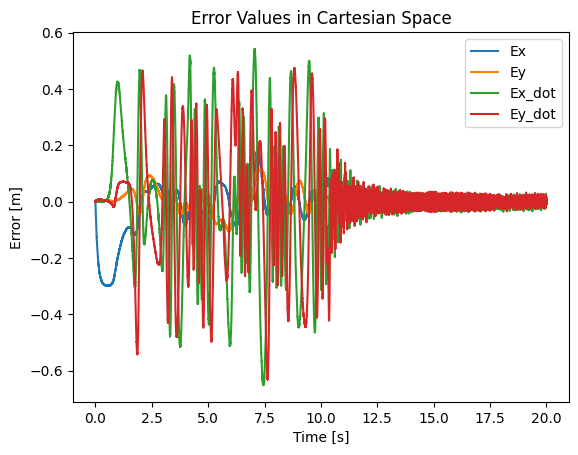

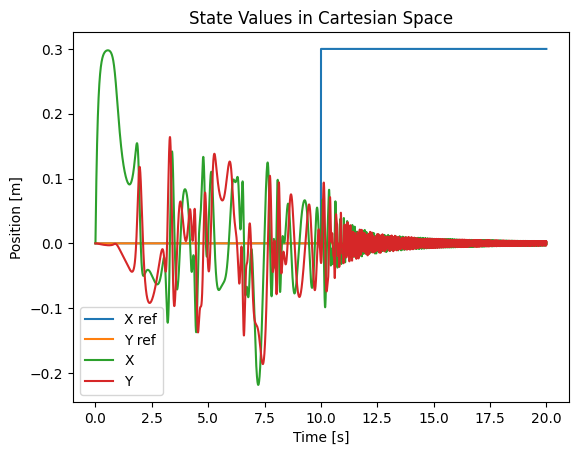

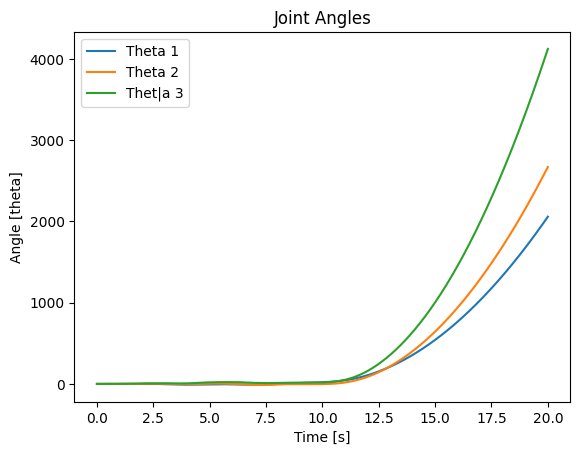

In [86]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Thet|a 3'])

## Nengo Adaptive - Random

In [25]:
class arm:
    def __init__(self, l, m, dt):
        self.l0 = l[0]
        self.l1 = l[1]
        self.l2 = l[2]
        
        self.m0 = m[0]
        self.m1 = m[1]
        self.m2 = m[2]
        
        #self.theta = theta
        #self.thetaDot = thetaDot
        self.dt = dt
    def __call__(self,t,inputs): #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
        theta_dot = np.zeros(6)
        JofXwrtQ3 = vJq(inputs[0:3],[self.l0,self.l1,self.l2]);
        JofXwrtQ2 = vJq(inputs[0:3],[self.l0,self.l1, 0]);
        JofXwrtQ1 = vJq(inputs[0:3],[self.l0, 0, 0]);

        Fg = np.matrix([0, -9.8, 0]).T;
        Fqg1 = JofXwrtQ1.T * Fg * self.m0;
        Fqg2 = JofXwrtQ2.T * Fg * self.m1;
        Fqg3 = JofXwrtQ3.T * Fg * self.m2;
        Fqg = Fqg1+Fqg2+Fqg3;
        
        #Find net torque
        Fqnet = Fqg + np.matrix(inputs[6:9]).T;
        
        #Get accerlation and velocity
        # Need joint limit check 
        theta_dot[3] = inputs[3] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2)
        theta_dot[4] = inputs[4] + self.dt*Fqnet.item(1)/(self.m1+self.m2)
        theta_dot[5] = inputs[5] + self.dt*Fqnet.item(2)/(self.m2)

        theta_dot[0] = inputs[0] + dt * inputs[3]
        theta_dot[1] = inputs[1] + dt * inputs[4]
        theta_dot[2] = inputs[2] + dt * inputs[5]
        
        return np.array(theta_dot)
def vJq(Theta,L):
    J = np.matrix(
            ([(-L[0]*np.sin(Theta[0])-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2]))],
            [(L[0]*np.cos(Theta[0])+L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[2]*np.cos(Theta[0]+Theta[1]+Theta[2]))],
            [0, 0, 0]))
    return J

In [448]:
#Model Parameters
num_neurons = 1000
basis_neurons = 100

#Sim parameters
T = 10
dt = 0.001
K = int(T/dt)
time = np.linspace(0,T,K)

#Sys parameters
l = [0.1,0.1,0.1]
m = [0.1,0.1,0.1]
sys = arm(l,m,dt)

# Control parameters
theta = np.zeros((3,2,K))
theta[:,:,0] = [[0,0],[0,0],[0,0]]
theta_dot_des = 0

lam = 0.7
ks = 20
weight_update_rate = 0#2e-6

seed = 11
model = nengo.Network(seed = seed)
with model:
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/g_x)*(ks*s + lam*e[2:4]) #u
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [u,theta]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return u_q #uq = [uq1,uq2,uq3]
        

    sys = nengo.Node(arm(l,m,dt),size_in = 9)
    
    #ref = nengo.Node( lambda t: [0.1*np.sin(t),0.1*np.cos(t),0.1*np.cos(t),-0.1*np.sin(t)]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 10 else [0.3,0,0,0]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    P_record = nengo.Ensemble(num_neurons,4,neuron_type = nengo.Direct()) #P_record = [Px,Py,Px_dot,Py_dot]
    #Ensemble
    #err = nengo.Ensemble(num_neurons,4,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
    #con = nengo.Ensemble(num_neurons,5, neuron_type = nengo.Direct()) #con = [ux,uy,theta1,theta2,theta3]
    err = nengo.Ensemble(num_neurons,4,radius = 0.4)#,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
    con = nengo.Ensemble(num_neurons,5,radius = con_rad, neuron_type = nengo.LIF())
    adaptive_basis = nengo.Ensemble(basis_neurons, 6)
    
    #Connections
    reference_input = nengo.Connection(ref,err)
    feedback = nengo.Connection(sys, err, function = qTx,transform = -1 ) 
    state_recorder = nengo.Connection(sys, P_record, function = qTx )
    controller = nengo.Connection(err,con[0:2],function = Sliding_Mode)
    theta_controller = nengo.Connection(sys[0:3],con[2:5])
    state_connection = nengo.Connection(sys,sys[0:6],synapse = 0)
    control_input = nengo.Connection(con,sys[6:9],function = JofQ)
    #Optional, provides more stable joints
    #theta_control = nengo.Connection(sys[3:6],sys[6:9], transform = -0.1)

    #Adaptive
    #adaptive_weights = nengo.Connection(adaptive_basis,sys[6:9], transform=np.zeros((3,6)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    #learing_rule = nengo.Connection(con,adaptive_weights.learning_rule,transform = -1, function = JofQ)
    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.01)
    reference_probe = nengo.Probe(target = ref, attr = 'output')
    state_probe = nengo.Probe(target = P_record, attr = 'decoded_output', synapse = 0.01)
    joint_probe = nengo.Probe(target = sys, attr = 'output')

with nengo.Simulator(model) as sim:
    sim.run(20.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

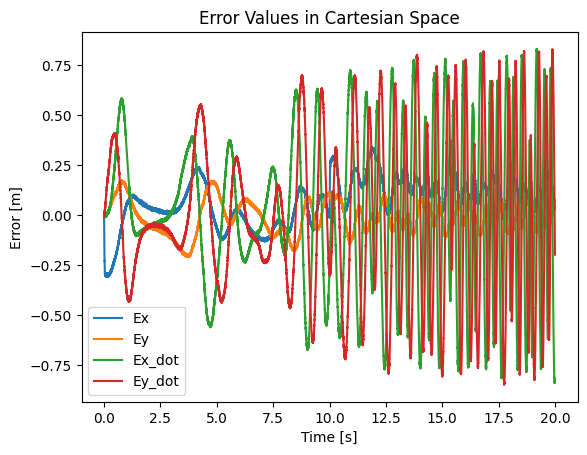

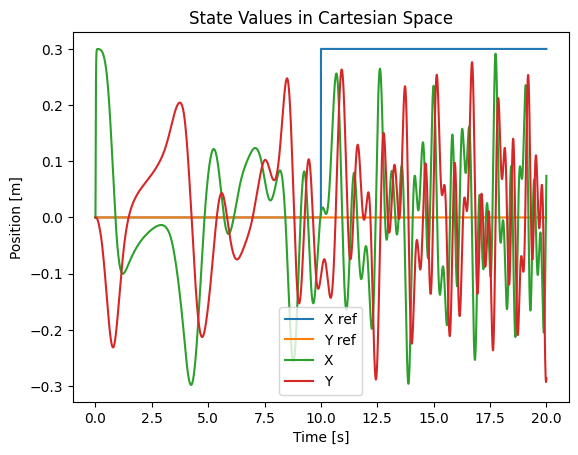

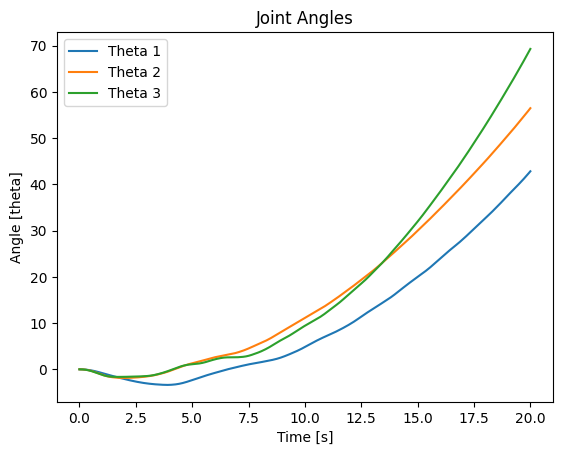

In [449]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Theta 3'])

## Nengo Adaptive - V3

In [40]:
#Model Parameters
num_neurons = 10000
basis_neurons = 1000
con_rad = 3
scale_factor = 100/con_rad
seed = 11
sim_time = 20
connection_synapse = 0.0
#Sys parameters
l = [0.1,0.1,0.1]
m = [0.1,0.1,0.1]

# Control parameters
lam = 0.5
ks = 30
dt = 0.0001
weight_update_rate = 0

In [41]:
class arm:
    def __init__(self, l, m, dt):
        self.l0 = l[0]
        self.l1 = l[1]
        self.l2 = l[2]
        
        self.m0 = m[0]
        self.m1 = m[1]
        self.m2 = m[2]
        
        #self.theta = theta
        #self.thetaDot = thetaDot
        self.dt = dt
    def __call__(self,t,inputs): #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
        theta_dot = np.zeros(6)
        JofXwrtQ3 = vJq(inputs[0:3],[self.l0,self.l1,self.l2]);
        JofXwrtQ2 = vJq(inputs[0:3],[self.l0,self.l1, 0]);
        JofXwrtQ1 = vJq(inputs[0:3],[self.l0, 0, 0]);

        Fg = np.matrix([0, -9.8, 0]).T;
        Fqg1 = JofXwrtQ1.T * Fg * self.m0;
        Fqg2 = JofXwrtQ2.T * Fg * self.m1;
        Fqg3 = JofXwrtQ3.T * Fg * self.m2;
        Fqg = Fqg1+Fqg2+Fqg3;
        
        #Find net torque
        Fqnet = Fqg + np.matrix(inputs[6:9]).T;
        
        #Get accerlation and velocity
        # Need joint limit check 
        theta_dot[3] = inputs[3] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2)
        theta_dot[4] = inputs[4] + self.dt*Fqnet.item(1)/(self.m1+self.m2)
        theta_dot[5] = inputs[5] + self.dt*Fqnet.item(2)/(self.m2)

        theta_dot[0] = inputs[0] + dt * inputs[3]
        theta_dot[1] = inputs[1] + dt * inputs[4]
        theta_dot[2] = inputs[2] + dt * inputs[5]
        
        return np.array(theta_dot)
def vJq(Theta,L):
    J = np.matrix(
            ([(-L[0]*np.sin(Theta[0])-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2]))],
            [(L[0]*np.cos(Theta[0])+L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[2]*np.cos(Theta[0]+Theta[1]+Theta[2]))],
            [0, 0, 0]))
    return J

In [46]:
seed = 11
#seed = 16
model = nengo.Network(seed = seed)
with model:
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/scale_factor)*(1/g_x)*(ks*s + lam*e[2:4]) #u
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [u,theta]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return scale_factor*u_q #uq = [uq1,uq2,uq3]
        

    sys = nengo.Node(arm(l,m,dt),size_in = 9)
    
    #ref = nengo.Node( lambda t: [0.1*np.sin(t),0.1*np.cos(t),0.1*np.cos(t),-0.1*np.sin(t)]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 10 else [0.3,0,0,0]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    P_record = nengo.Ensemble(num_neurons,4,neuron_type = nengo.Direct()) #P_record = [Px,Py,Px_dot,Py_dot]
    #Ensemble
    err = nengo.Ensemble(num_neurons,4,radius = 0.4)#, neuron_type = nengo.Direct())#,neuron_type = nengo.Direct(), neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
    #con = nengo.Ensemble(num_neurons,5,radius = 10, neuron_type = nengo.Direct()) #con = [ux,uy,theta1,theta2,theta3]
    con = nengo.Ensemble(num_neurons,5,radius = con_rad)#, neuron_type = nengo.Direct())
    adaptive_basis = nengo.Ensemble(basis_neurons, 6)#, neuron_type = nengo.Direct())#, neuron_type = nengo.Direct())

    
    #Connections
    reference_input = nengo.Connection(ref,err, synapse = connection_synapse)
    feedback = nengo.Connection(sys, err, function = qTx,transform = -1 , synapse = connection_synapse) 
    state_recorder = nengo.Connection(sys, P_record, function = qTx , synapse = connection_synapse)
    controller = nengo.Connection(err,con[0:2],function = Sliding_Mode, synapse = connection_synapse)
    theta_controller = nengo.Connection(sys[0:3],con[2:5], synapse = connection_synapse)
    state_connection = nengo.Connection(sys,sys[0:6],synapse = 0)
    control_input = nengo.Connection(con,sys[6:9],function = JofQ, synapse = connection_synapse)
    
    adaptive_input = nengo.Connection(sys[0:6],adaptive_basis,synapse = connection_synapse)
    
    #Optional, provides more stable joints
    #theta_control = nengo.Connection(sys[3:6],sys[6:9], transform = -0.1)

    #Adaptive
    #adaptive_weights = nengo.Connection(adaptive_basis,sys[6:9], transform=np.zeros((3,6)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    #learing_rule = nengo.Connection(con,adaptive_weights.learning_rule,transform = -1, function = JofQ)
    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.1)
    reference_probe = nengo.Probe(target = ref, attr = 'output')
    state_probe = nengo.Probe(target = P_record, attr = 'decoded_output', synapse = 0.1)
    joint_probe = nengo.Probe(target = sys, attr = 'output')
    con_probe = nengo.Probe(target = con, attr = 'decoded_output', synapse = 0.1)
    control_input = nengo.Probe(target = control_input, attr = 'output', synapse = 0.1 )
    adaptive_probe = nengo.Probe(target = adaptive_weights, attr = 'output')
with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

BuildError: Attribute 'weighted' is not probeable on <Connection from <Ensemble (unlabeled) at 0x26ae68888f0> to <Node (unlabeled) at 0x26ac1ff7560>[6:9]>.

In [ ]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Thet|a 3'])

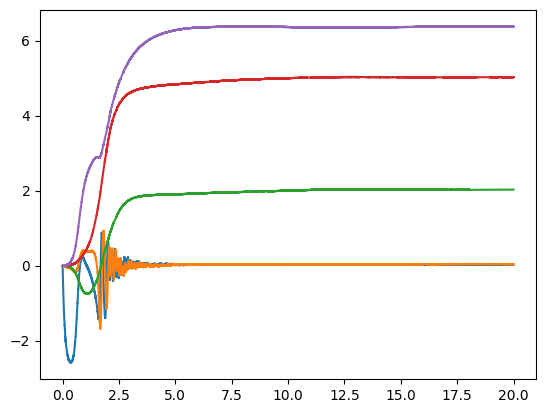

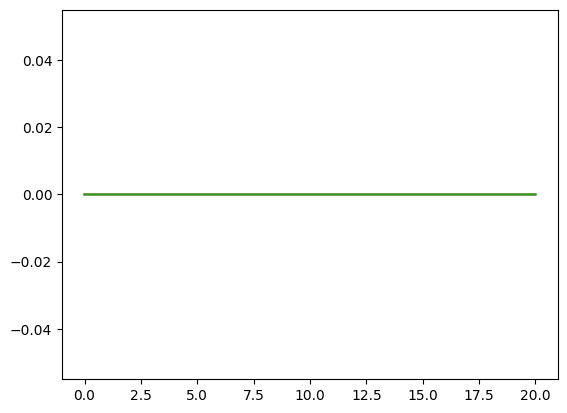

In [45]:
plt.figure()
con_sig = sim.data[con_probe]
plt.plot(t,con_sig)
plt.figure()
adaptive_con_sig = sim.data[adaptive_probe]
plt.plot(t,adaptive_con_sig)

### Save Plots

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

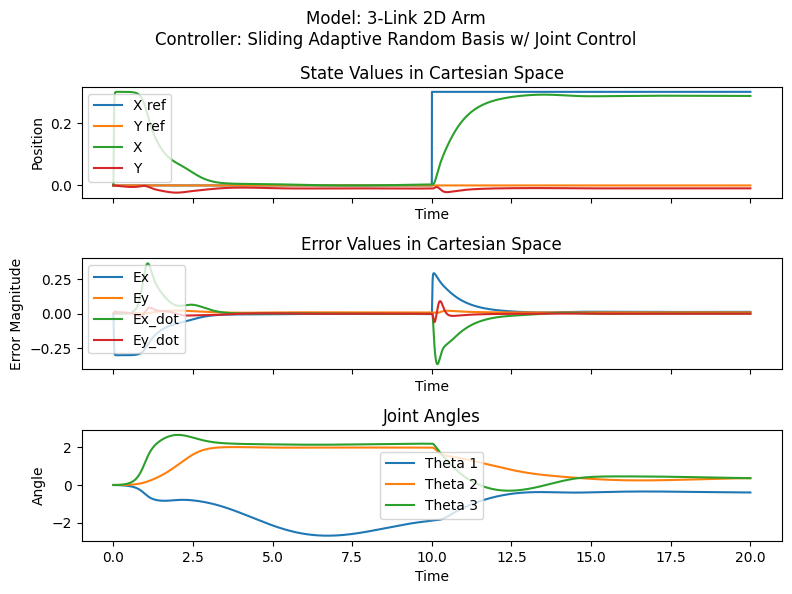

In [159]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = sim.data[state_probe]
joint_signal = sim.data[joint_probe]

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes = axes.flatten()

fig.suptitle('Model: 3-Link 2D Arm\nController: Sliding Adaptive Random Basis w/ Joint Control')

axes[0].plot(t,ref_signal[:,0:2])
axes[0].plot(t,state_signal[:,0:2])
axes[0].legend(['X ref','Y ref','X','Y'])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Position')
axes[0].set_title("State Values in Cartesian Space")

axes[1].plot(t,error_signal)
axes[1].legend(['Ex','Ey','Ex_dot','Ey_dot'])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Error Magnitude')
axes[1].set_title("Error Values in Cartesian Space")


axes[2].plot(t,joint_signal[:,0:3])
axes[2].set_title("Joint Angles")
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Angle')
axes[2].legend(['Theta 1','Theta 2','Theta 3'])
plt.tight_layout(pad=1.0)
output_directory = "subplots_output"
os.makedirs(output_directory, exist_ok=True)
output_file = os.path.join(output_directory, "Arm_Random_Basis.png")
plt.savefig(output_file)
plt.close

## Nengo Adaptive - Selected Basis

In [6]:
# Choose encoders

x_lim = [-np.pi,np.pi]
xdot_lim =  [-np.pi,np.pi]

e_2d = np.array([np.linspace(x_lim[0],x_lim[1],basis_neurons),np.linspace(x_lim[0],x_lim[1],basis_neurons),np.linspace(x_lim[0],x_lim[1],basis_neurons),np.linspace(xdot_lim[0],xdot_lim[1],basis_neurons),np.linspace(xdot_lim[0],xdot_lim[1],basis_neurons),np.linspace(xdot_lim[0],xdot_lim[1],basis_neurons)])
e_3d = np.zeros((7,basis_neurons))
for i in range(basis_neurons):
    x_norm = np.linalg.norm(e_2d[:,i])
    z = np.append(2*e_2d[:,i]/(1+x_norm**2),(1-x_norm**2)/(1+x_norm**2))
    e_3d[:,i] = z
e_3d = np.transpose(e_3d)

In [59]:
#Model Parameters
num_neurons = 1000
basis_neurons = 100

#Sim parameters
T = 10
dt = 0.001
K = int(T/dt)
time = np.linspace(0,T,K)

#Sys parameters
l = [0.1,0.1,0.1]
m = [0.1,0.1,0.1]
sys = arm(l,m,dt)

# Control parameters
theta = np.zeros((3,2,K))
theta[:,:,0] = [[0,0],[0,0],[0,0]]
theta_dot_des = 0

lam = 0.7
ks = 20
weight_update_rate = 2e-6

model = nengo.Network()
with model:
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/g_x)*(ks*s + lam*e[2:4]) #u
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [u,theta]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return u_q #uq = [uq1,uq2,uq3]
        

    sys = nengo.Node(arm(l,m,dt),size_in = 9)
    
    #ref = nengo.Node( lambda t: [0.1*np.sin(t),0.1*np.cos(t),0.1*np.cos(t),-0.1*np.sin(t)]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 10 else [0.3,0,0,0]) #ref = [Xdes,ydes, Xdotdes,ydotdes]
    P_record = nengo.Ensemble(num_neurons,4,neuron_type = nengo.Direct()) #P_record = [Px,Py,Px_dot,Py_dot]
    #Ensemble
    err = nengo.Ensemble(num_neurons,4,neuron_type = nengo.Direct()) #err = [ex,ey,exdot,eydot]
    con = nengo.Ensemble(num_neurons,5, neuron_type = nengo.Direct()) #con = [ux,uy,theta1,theta2,theta3]
    adaptive_basis = nengo.Ensemble(basis_neurons, 7, encoders = e_3d)
    
    #Connections
    reference_input = nengo.Connection(ref,err)
    feedback = nengo.Connection(sys, err, function = qTx,transform = -1 ) 
    state_recorder = nengo.Connection(sys, P_record, function = qTx )
    controller = nengo.Connection(err,con[0:2],function = Sliding_Mode)
    theta_controller = nengo.Connection(sys[0:3],con[2:5])
    state_connection = nengo.Connection(sys,sys[0:6],synapse = 0)
    control_input = nengo.Connection(con,sys[6:9],function = JofQ)
    #Optional, provides more stable joints
    theta_control = nengo.Connection(sys[3:6],sys[6:9], transform = -0.1)

    #Adaptive
    adaptive_weights = nengo.Connection(adaptive_basis,sys[6:9], transform=np.zeros((3,7)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    learing_rule = nengo.Connection(con,adaptive_weights.learning_rule,transform = -1, function = JofQ)
    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.01)
    reference_probe = nengo.Probe(target = ref, attr = 'output')
    state_probe = nengo.Probe(target = P_record, attr = 'decoded_output', synapse = 0.01)
    joint_probe = nengo.Probe(target = sys, attr = 'output')
    adaptive_probe = nengo.Probe(target = adaptive_weights, attr = 'output', synapse = 0.01)
    learning_probe = nengo.Probe(target = learing_rule, attr = 'output', synapse = 0.01)

with nengo.Simulator(model) as sim:
    sim.run(20.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

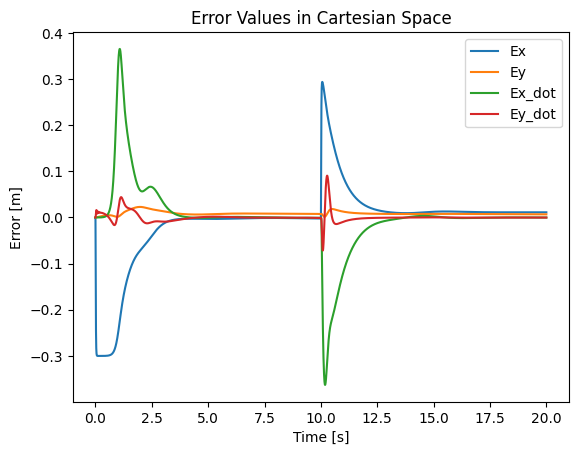

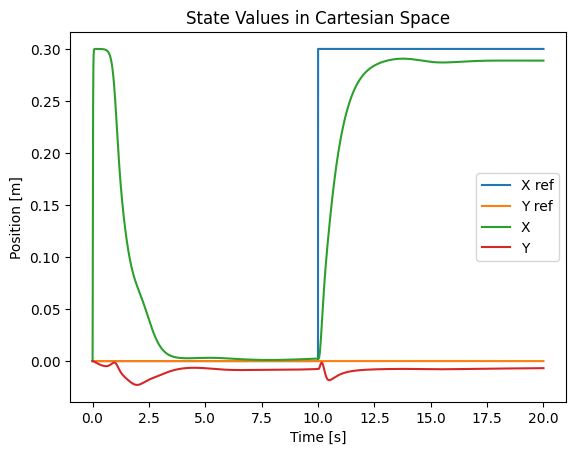

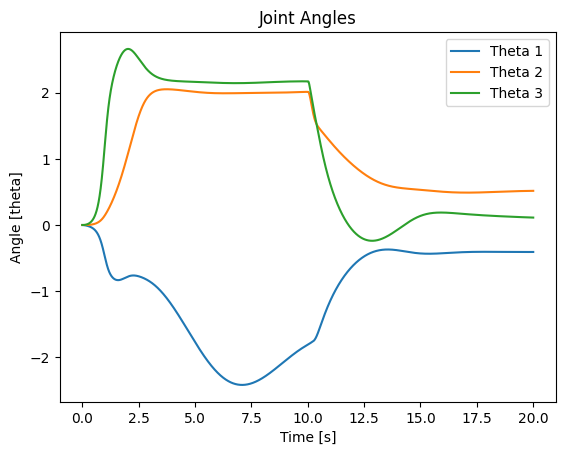

In [60]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Theta 3'])

### Save Plots

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

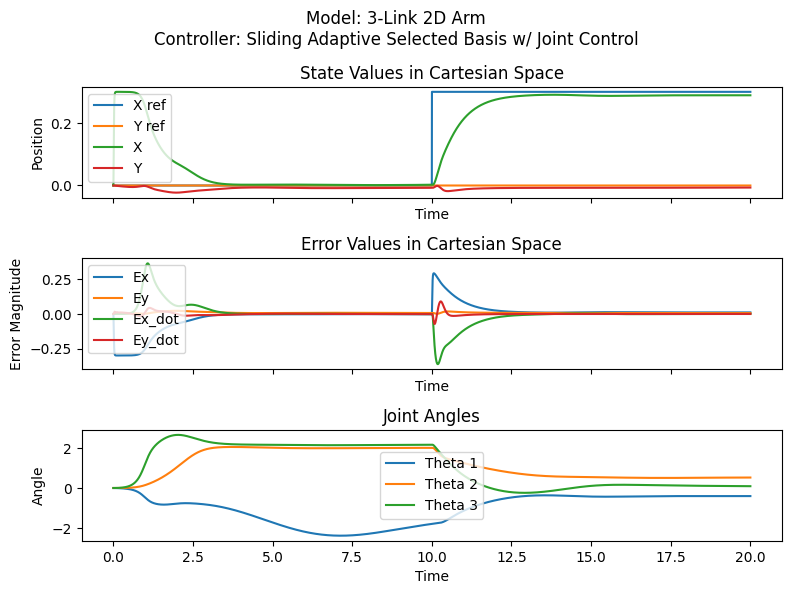

In [156]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = sim.data[state_probe]
joint_signal = sim.data[joint_probe]

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes = axes.flatten()

fig.suptitle('Model: 3-Link 2D Arm\nController: Sliding Adaptive Selected Basis w/ Joint Control')

axes[0].plot(t,ref_signal[:,0:2])
axes[0].plot(t,state_signal[:,0:2])
axes[0].legend(['X ref','Y ref','X','Y'])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Position')
axes[0].set_title("State Values in Cartesian Space")

axes[1].plot(t,error_signal)
axes[1].legend(['Ex','Ey','Ex_dot','Ey_dot'])
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Error Magnitude')
axes[1].set_title("Error Values in Cartesian Space")


axes[2].plot(t,joint_signal[:,0:3])
axes[2].set_title("Joint Angles")
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Angle')
axes[2].legend(['Theta 1','Theta 2','Theta 3'])
plt.tight_layout(pad=1.0)
output_directory = "subplots_output"
os.makedirs(output_directory, exist_ok=True)
output_file = os.path.join(output_directory, "Arm_Selected_Basis.png")
plt.savefig(output_file)
plt.close

## Arm - Numerical Controller, Spiking Adaptive

In [141]:
class arm:
    def __init__(self, l, m, dt):
        self.l0 = l[0]
        self.l1 = l[1]
        self.l2 = l[2]
        
        self.m0 = m[0]
        self.m1 = m[1]
        self.m2 = m[2]
        
        #self.theta = theta
        #self.thetaDot = thetaDot
        self.dt = dt
    def __call__(self,t,inputs): #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
        theta_dot = np.zeros(6)
        JofXwrtQ3 = vJq(inputs[0:3],[self.l0,self.l1,self.l2]);
        JofXwrtQ2 = vJq(inputs[0:3],[self.l0,self.l1, 0]);
        JofXwrtQ1 = vJq(inputs[0:3],[self.l0, 0, 0]);

        Fg = np.matrix([0, -9.8, 0]).T;
        Fqg1 = JofXwrtQ1.T * Fg * self.m0;
        Fqg2 = JofXwrtQ2.T * Fg * self.m1;
        Fqg3 = JofXwrtQ3.T * Fg * self.m2;
        Fqg = Fqg1+Fqg2+Fqg3;
        
        #Find net torque
        Fqnet = Fqg + np.matrix(inputs[6:9]).T;
        
        #Get accerlation and velocity
        # Need joint limit check 
        theta_dot[3] = inputs[3] + self.dt*Fqnet.item(0)/(self.m0+self.m1+self.m2)
        theta_dot[4] = inputs[4] + self.dt*Fqnet.item(1)/(self.m1+self.m2)
        theta_dot[5] = inputs[5] + self.dt*Fqnet.item(2)/(self.m2)

        theta_dot[0] = inputs[0] + dt * inputs[3]
        theta_dot[1] = inputs[1] + dt * inputs[4]
        theta_dot[2] = inputs[2] + dt * inputs[5]
        
        return np.array(theta_dot)
def vJq(Theta,L):
    J = np.matrix(
            ([(-L[0]*np.sin(Theta[0])-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[1]*np.sin(Theta[0]+Theta[1])-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2])), (-L[2]*np.sin(Theta[0]+Theta[1]+Theta[2]))],
            [(L[0]*np.cos(Theta[0])+L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[1]*np.cos(Theta[0]+Theta[1])+L[2]*np.cos(Theta[0]+Theta[1]+Theta[2])), (L[2]*np.cos(Theta[0]+Theta[1]+Theta[2]))],
            [0, 0, 0]))
    return J




## No Adaptive

In [183]:

#Sim parameters
sim_time = 40

#Model parameters
num_neurons = 1000
sim_synapse = 0
ks = 20
lam = 0.7
weight_update_rate = 2e-5
model_neurons = nengo.Direct()

#Sys parameters
dt = 0.001
L = [0.1,0.1,0.1]
M = [0.1,0.1,0.1]

model = nengo.Network()
with model:
    #Functions
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/g_x)*(ks*s + lam*e[2:4]) #u = [ux,uy]
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return u_q #uq = [uq1,uq2,uq3]
        
    #Nodes
    
    sys = nengo.Node(arm(L,M,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                              #outputs = [theta,theta_dot] -> [0:3,3:6]
    #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
    
    #Ensembles
    err = nengo.Ensemble(num_neurons,4,neuron_type = model_neurons) #err = [ex,ey,exdot,eydot]
    con = nengo.Ensemble(num_neurons,5, neuron_type = model_neurons) #con = [ux,uy,q1,q2,q3]
    
    #Connections
    state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
    ref_in = nengo.Connection(ref,err, synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
    feedback = nengo.Connection(sys,err,function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
    uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
    control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
    control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
    #Theta Control
    theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]

    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.1)
    reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0.01)
    state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0.01)
    joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0.01)
    con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0.01)
    control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0.01)

with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

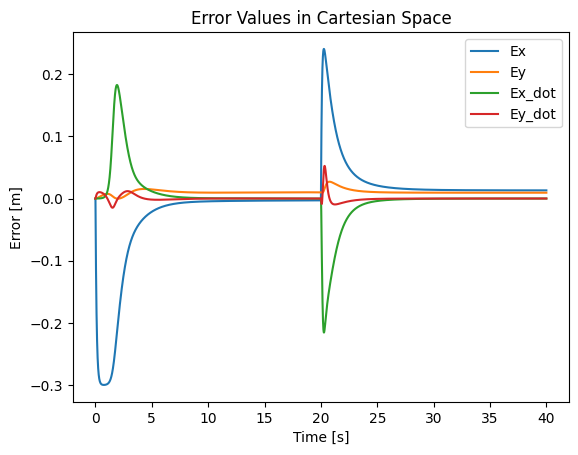

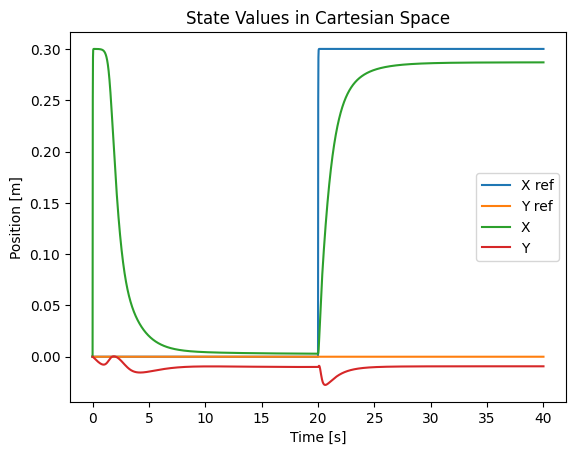

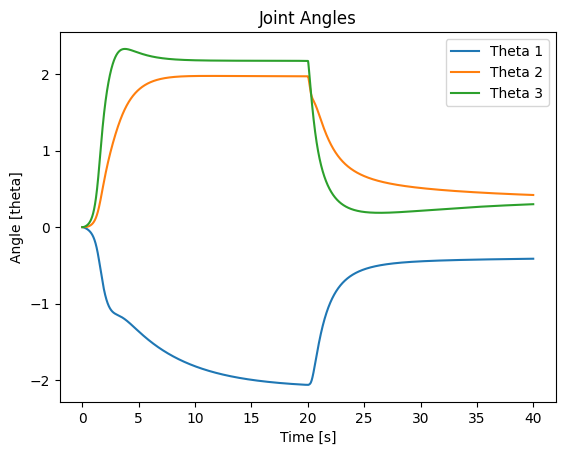

In [184]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = -sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])

plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Theta 3'])

## Random Basis

In [255]:

#Sim parameters
sim_time = 40

#Model parameters
num_neurons = 1000
sim_synapse = 0
ks = 20
lam = 0.7
weight_update_rate = 2e-5
model_neurons = nengo.Direct()
rho_specified = 0.421

#Sys parameters
dt = 0.001
L = [0.1,0.1,0.1]
M = [0.1,0.1,0.1]

model = nengo.Network()
with model:
    #Functions
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/g_x)*(ks*s + lam*e[2:4]) #u = [ux,uy]
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return u_q #uq = [uq1,uq2,uq3]
    #Nodes
    
    sys = nengo.Node(arm(L,M,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                              #outputs = [theta,theta_dot] -> [0:3,3:6]
    #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
    
    #Ensembles
    err = nengo.Ensemble(num_neurons,4,neuron_type = model_neurons) #err = [ex,ey,exdot,eydot]
    con = nengo.Ensemble(num_neurons,5, neuron_type = model_neurons) #con = [ux,uy,q1,q2,q3]
    
    #Connections
    state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
    ref_in = nengo.Connection(ref,err, synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
    feedback = nengo.Connection(sys,err,function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
    uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
    control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
    control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
    #Theta Control
    theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]

    #Adaptive
    #adaptive_basis = nengo.Ensemble(100,6)
    #adaptive_activation = nengo.Connection(sys,adaptive_basis)
    #adaptive_weights = nengo.Connection(adaptive_basis,sys[6:9], transform=np.zeros((3,6)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    #learing_rule = nengo.Connection(con,adaptive_weights.learning_rule,transform = -1, function = JofQ)
    adaptive_basis = nengo.Ensemble(1000,4)
    adaptive_activation = nengo.Connection(sys,adaptive_basis,function = qTx)
    adaptive_weights = nengo.Connection(adaptive_basis,con[0:2], transform=np.zeros((2,4)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    learing_rule = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode)    
    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.01)
    reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0.01)
    state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0.01)
    joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0.01)
    con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0.01)
    control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0.01)

with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

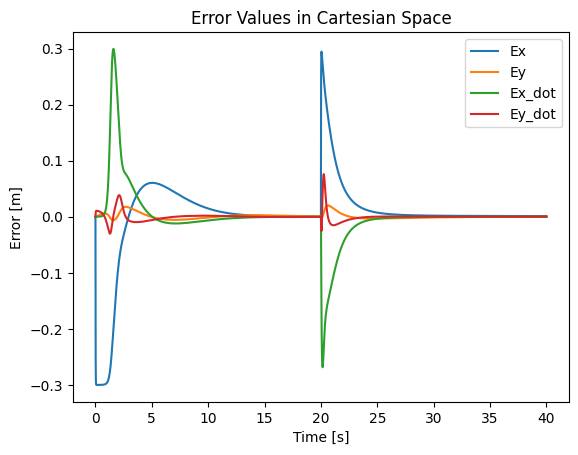

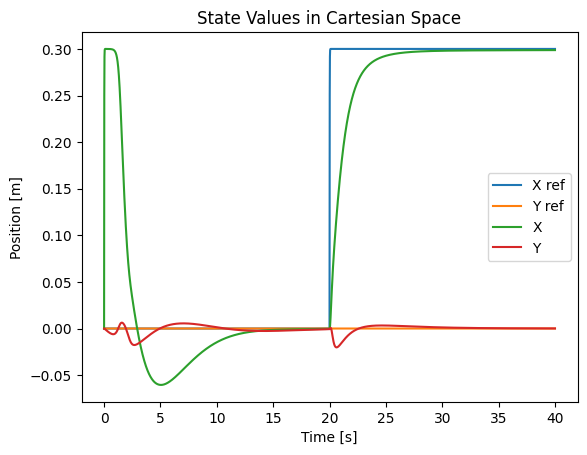

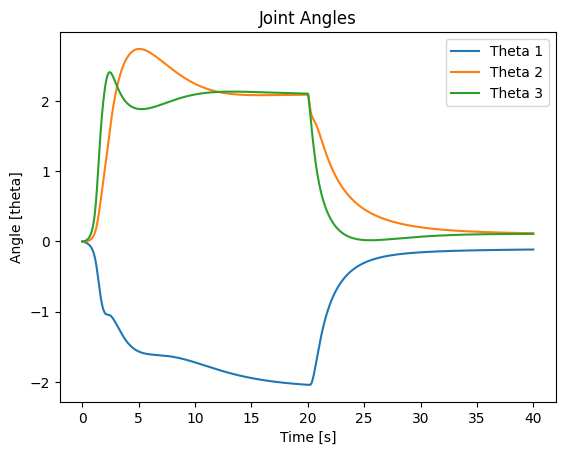

In [256]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = -sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])
plt.savefig('Random_basis_operational_space')
plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])
plt.savefig('Random_basis_error')
plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Theta 3'])
plt.savefig('Random_basis_joint_space')

## Projected Basis

In [249]:
#For selected basis
#Chooses encoders on D+1 hypersphere
def projection(X): 
    n = len(X) + 1
    X_proj = np.zeros(n)
    X_proj[-1] =  np.prod(np.sin(X))
    for i in range(n-2, -1, -1):
        X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
    return X_proj
def selected_encoders(dim,num_neurons):
    X = np.zeros((dim,num_neurons))
    for d in range(dim):
        X[d,:] = np.linspace(-np.pi,np.pi,num_neurons)
    X_proj = np.zeros((dim+1,num_neurons))
    for n in range(num_neurons):
        X_proj[:,n] = projection(X[:,n])
    return np.transpose(X_proj)
def sparsity_to_x_intercept(d, p):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d-1)/2.0, 0.5, 2*p))

In [250]:

#Sim parameters
sim_time = 40

#Model parameters
num_neurons = 1000
basis_neurons = 1000
sim_synapse = 0
ks = 20
lam = 0.7
weight_update_rate = 2e-5
model_neurons = nengo.Direct()
adaptive_neuron_type = nengo.LIF()
gain  = 100
#Sys parameters
dt = 0.001
L = [0.1,0.1,0.1]
M = [0.1,0.1,0.1]
x_mean = [0,0,0,0]
limits = [0.3,0.3,-1,1]

model = nengo.Network()
with model:
    #Functions
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/g_x)*(ks*s + lam*e[2:4]) #u = [ux,uy]
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return u_q #uq = [uq1,uq2,uq3]
        
    def input_projection(X): #Projects states into D+1 hypersphere (Selected basis only)
        X = qTx(X)
        X = np.divide(X-x_mean,np.asarray(limits))
        n = len(X) + 1
        X_proj = np.zeros(n)
        X_proj[-1] =  np.prod(np.sin(X))
        for i in range(n-2, -1, -1):
            X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
        return X_proj
    #Nodes
    
    sys = nengo.Node(arm(L,M,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                              #outputs = [theta,theta_dot] -> [0:3,3:6]
    #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
    
    #Ensembles
    err = nengo.Ensemble(num_neurons,4,neuron_type = model_neurons) #err = [ex,ey,exdot,eydot]
    con = nengo.Ensemble(num_neurons,5, neuron_type = model_neurons) #con = [ux,uy,q1,q2,q3]
    
    #Connections
    state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
    ref_in = nengo.Connection(ref,err, synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
    feedback = nengo.Connection(sys,err,function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
    uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
    control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
    control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
    #Theta Control
    theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]

    #Adaptive
    xi = - sparsity_to_x_intercept( d = 4, p = rho_specified )
    adaptive_basis = nengo.Ensemble(basis_neurons,5,
                                    encoders = selected_encoders(4,basis_neurons),
                                    gain = gain*np.ones(basis_neurons),
                                    bias = np.zeros(basis_neurons)+xi,
                                    neuron_type = adaptive_neuron_type) 
    adaptive_weights = nengo.Connection(adaptive_basis,con[0:2], transform=np.zeros((2,5)), learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,transform = -1, function = Sliding_Mode) 
    adaptive_input = nengo.Connection(sys,adaptive_basis, function = input_projection) #(sys,adaptive_basis,function = qTx) 
    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.01)
    reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0.01)
    state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0.01)
    joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0.01)
    con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0.01)
    control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0.01)

with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

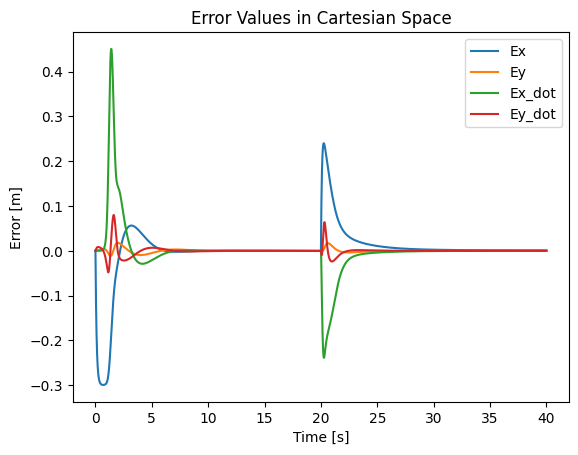

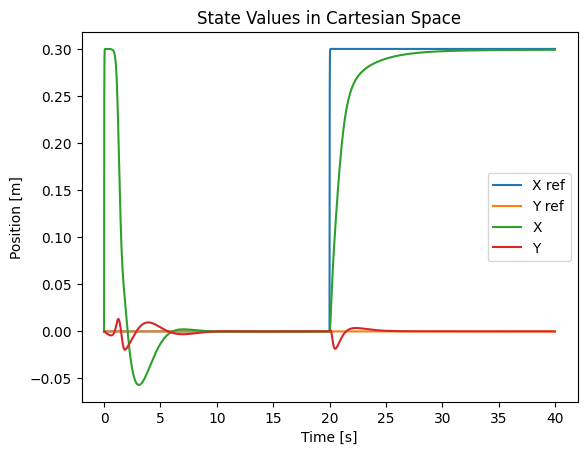

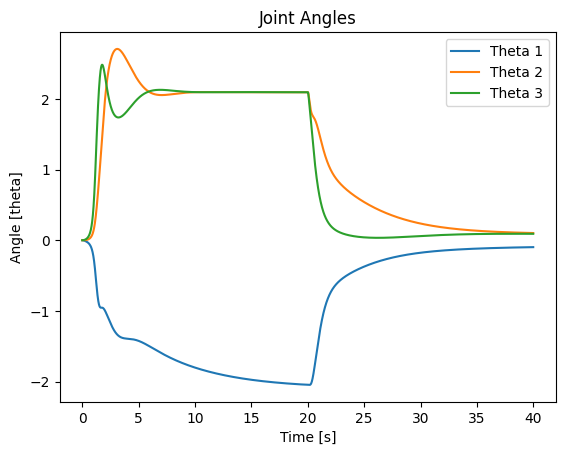

In [251]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = -sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])
plt.savefig('Selected_basis_operational_space')

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])
plt.savefig('Selected_basis_error')
plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Theta 3'])

plt.savefig('Selected_basis_joint_space')

## SSP Basis

In [252]:


def make_unitary_matrix_fourier( ssp_dim, domain_dim, eps=1e-3, rng = np.random, psd_sampling = 'uniform' ):
    if psd_sampling == 'gaussian':
        # gaussian kernel
        a = rng.normal( loc = 0., scale = 1., size = ( (ssp_dim - 1)//2, domain_dim) )
        phi = np.pi * (eps + a * (1 - 2 * eps))
    
    elif psd_sampling == 'uniform':
        # sinc kernel
        a = rng.rand( (ssp_dim - 1)//2, domain_dim )
        sign = rng.choice((-1, +1), size=np.shape(a) )
        phi = sign * np.pi * (eps + a * (1 - 2 * eps))
    
    fv = np.zeros( (ssp_dim,domain_dim), dtype='complex64')
    fv[0,:] = 1

    fv[1:(ssp_dim + 1) // 2,:] = phi
    fv[-1:ssp_dim // 2:-1,:] = -fv[1:(ssp_dim + 1) // 2,:]
    
    if ssp_dim % 2 == 0:
        fv[ssp_dim // 2,:] = 1

    return fv

class SSPEncoder:
    def __init__(self, phase_matrix, length_scale):
        '''
        Represents a domain using spatial semantic pointers.

        Parameters:
        -----------

        phase_matrix : np.ndarray
            A ssp_dim x domain_dim ndarray representing the frequency 
            components of the SSP representation.

        length_scale : float or np.ndarray
            Scales values before encoding.
        '''
        self.phase_matrix = phase_matrix

        self.domain_dim = self.phase_matrix.shape[1]
        self.ssp_dim = self.phase_matrix.shape[0]
        self.update_lengthscale(length_scale)

    def update_lengthscale(self, scale):
        '''
        Changes the lengthscale being used in the encoding.
        '''
        if not isinstance(scale, np.ndarray) or scale.size == 1:
            self.length_scale = scale * np.ones((self.domain_dim,))
        else:
            assert scale.size == self.domain_dim
            self.length_scale = scale
        assert self.length_scale.size == self.domain_dim
    
    def encode(self,x):
        '''
        Transforms input data into an SSP representation.

        Parameters:
        -----------
        x : np.ndarray
            A (num_samples, domain_dim) array representing data to be encoded.

        Returns:
        --------
        data : np.ndarray
            A (num_samples, ssp_dim) array of the ssp representation of the data
            
        '''
        
        x = np.atleast_2d(x)
        ls_mat = np.atleast_2d(np.diag(1/self.length_scale.flatten()))
        
        assert ls_mat.shape == (self.domain_dim, self.domain_dim), f'Expected Len Scale mat with dimensions {(self.domain_dim, self.domain_dim)}, got {ls_mat.shape}'
        scaled_x = x @ ls_mat
        data = np.fft.ifft( np.exp( 1.j * self.phase_matrix @ scaled_x.T), axis=0 ).real
        
        return data.T

def RandomSSPSpace(domain_dim, ssp_dim, length_scale = None, 
                   rng = np.random.default_rng(), psd_sampling = 'uniform' ):
    
    phase_matrix = make_unitary_matrix_fourier(ssp_dim,domain_dim, psd_sampling = psd_sampling )

    if isinstance(length_scale,float):
        length_scale = np.array( np.tile(length_scale,domain_dim) )
    else:
        length_scale = np.array( length_scale )
    return SSPEncoder(phase_matrix, length_scale=length_scale)
    
    
def encode_rff( x, n_features, length_scale, kernel = 'gaussian', coefficient = 1., n_functions = 1):
    # print(type(x))
    
    # dimensionality of feature space
    x_dim = x.shape[-1]
    omega_shape = (n_functions, n_features, x_dim)
    
    if kernel == 'gaussian':
        omega = np.random.normal( size = omega_shape )
        
    # Scale omegas by lengthscale
    omega = omega / length_scale

    phi = np.random.uniform( low = 0., high = (2 * np.pi), size = (n_functions, n_features, 1) )
    
    features = np.cos( np.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / n_features) ** 0.5 * features * coefficient

    return features[0,:,:].T

In [253]:

#Sim parameters
sim_time = 40

#Model parameters
num_neurons = 1000
basis_neurons = 1000
sim_synapse = 0
ks = 20
lam = 0.7
weight_update_rate = 2e-5
model_neurons = nengo.Direct()
adaptive_neuron_type = nengo.LIF()
gain  = 100
#Sys parameters
dt = 0.001
L = [0.1,0.1,0.1]
M = [0.1,0.1,0.1]
x_mean = [0,0,0,0]
limits = [0.3,0.3,-1,1]

#SSP Parameters
#SSP 
domain_ranges_ = np.array([[-0.3,0.3],[-1.,1.],[-0.3,0.3],[-1.,1.]])
ssp_dim = 512
rho_specified = 0.421
#encoders_type = 'random'
encoders_type = 'place-cells'
psd_sampling = 'gaussian'
length_scale = np.asarray([[0.82,5.31,0.5,5]])
gain = 100

model = nengo.Network()
with model:
    #Functions
    def Sliding_Mode(e): #e = [ex, ey, edotx, edoty] -> u = [ux,uy]
        s = e[0:2] + lam*e[2:4]
        g_x = m[2]
        return (1/g_x)*(ks*s + lam*e[2:4]) #u = [ux,uy]
        
    def qTx(Q): #Takes joint inputs and converts to end effector
        # Q = [q1,q2,q3,qdot1,qdot2,qdot3] -> p = [px, py, pdotx, pdoty]
        
        p0 = np.array([0,0])
        
        p1 = p0 + np.array([l[0]*np.cos(Q[0]),l[0]*np.sin(Q[0])])
        p2 = p1 + np.array([l[0]*np.cos(Q[0]+Q[1]),l[0]*np.sin(Q[0]+Q[1])])
        p3 = p2 + np.array([l[0]*np.cos(Q[0]+Q[1]+Q[2]),l[0]*np.sin(Q[0]+Q[1]+Q[2])])
       
        JofX = vJq(Q[0:3],l)
        P_dot = np.array(np.matmul(JofX,Q[3:6])).flatten()[0:2]
    
        return np.append(p3,P_dot) # p = [px, py, pdotx, pdoty]
        
    def JofQ(x): #Move signal to joint space
        # x = [ux,uy,q1,q2,q3] -> uq = [uq1,uq2,uq3]
        u = np.append(x[0:2],0)
        theta = x[2:5]
        JofX = vJq(theta,l)
        u_q = np.matmul(JofX.T,u.T)
        return u_q #uq = [uq1,uq2,uq3]
        
    def input_projection(X): #Projects states into D+1 hypersphere (Selected basis only)
        X = qTx(X)
        X = np.divide(X-x_mean,np.asarray(limits))
        n = len(X) + 1
        X_proj = np.zeros(n)
        X_proj[-1] =  np.prod(np.sin(X))
        for i in range(n-2, -1, -1):
            X_proj[i] = np.prod(np.sin(X[:i])) * np.cos(X[i])
        return X_proj
    #Nodes
    
    sys = nengo.Node(arm(L,M,dt),size_in = 9) #inputs = [theta,theta_dot,U] -> [0:3,3:6,6:9] 
                                              #outputs = [theta,theta_dot] -> [0:3,3:6]
    #ref = nengo.Node([0,0.3,0,0]) #ref = [x_ref,y_ref,x_dot_ref, y_dot_ref]
    ref = nengo.Node( lambda t: [0,0,0,0] if t < 20 else [0.3,0,0,0])
    
    #Ensembles
    err = nengo.Ensemble(num_neurons,4,neuron_type = model_neurons) #err = [ex,ey,exdot,eydot]
    con = nengo.Ensemble(num_neurons,5, neuron_type = model_neurons) #con = [ux,uy,q1,q2,q3]
    
    #Connections
    state_feedback = nengo.Connection(sys,sys[0:6],synapse = sim_synapse) #sys[theta,theta_dot] -> sys[theta,theta_dot]
    ref_in = nengo.Connection(ref,err, synapse = sim_synapse) # ref[x_ref,y_ref,x_dot_ref, y_dot_ref] -> err[ex,ey,exdot,eydot]
    feedback = nengo.Connection(sys,err,function = qTx,transform = -1,synapse = sim_synapse) #sys[theta,theta_dot] -(-qTx)-> err[ex,ey,exdot,eydot]
    uxy = nengo.Connection(err,con[0:2],function = Sliding_Mode,synapse = sim_synapse) #err[ex,ey,exdot,eydot] -(Sliding_Mode)-> con[ux,uy]
    control_state = nengo.Connection(sys[0:3],con[2:5],synapse = sim_synapse) #sys[q1,q2,q3] -> con[q1,q2,q3]
    control_input = nengo.Connection(con,sys[6:9],function = JofQ,synapse = sim_synapse) #con[ux,uy,q1,q2,q3] -(JofQ)-> sys[uq1,uq2,uq3]
    #Theta Control
    theta_control = nengo.Connection(sys[3:6], sys[6:9], transform = -1) #sys[theta_dot] -(-1)-> sys[uq1,uq2,uq3]

    #Adaptive
    ssp_embedding = RandomSSPSpace( domain_dim = 4, 
                                   ssp_dim = ssp_dim, 
                                   length_scale = length_scale, 
                                   psd_sampling = psd_sampling )
    xi = - sparsity_to_x_intercept( d = ssp_dim, p = rho_specified )
    
    def encode_ssp(t,x):
        #print(x)
        return ssp_embedding.encode(x).flatten()

    if encoders_type == 'random':
        encoders = nengo.dists.UniformHypersphere(surface=True).sample(basis_neurons, ssp_dim)
    elif encoders_type == 'place-cells':
        e_xs = np.random.uniform(low=domain_ranges_[:,0],high=domain_ranges_[:,1],size=(basis_neurons,ssp_embedding.domain_dim))
        encoders = ssp_embedding.encode(e_xs)

    # create ensemble; random encoders for now
    adaptive_basis = nengo.Ensemble(n_neurons = basis_neurons, 
                              dimensions = ssp_embedding.ssp_dim,
                              gain = gain*np.ones(basis_neurons),
                              bias = np.zeros(basis_neurons) + xi,
                              neuron_type = adaptive_neuron_type,
                              encoders = encoders,
                              normalize_encoders = False,
                             )
    ssp_node = nengo.Node(encode_ssp,size_in=4)
    nengo.Connection(sys,ssp_node,function = qTx)
    nengo.Connection(ssp_node,adaptive_basis)            
    adaptive_weights = nengo.Connection(adaptive_basis,con[0:2],transform = np.zeros((2,adaptive_basis.dimensions)),learning_rule_type=nengo.PES(learning_rate=weight_update_rate))
    learning_sig = nengo.Connection(err,adaptive_weights.learning_rule,function = Sliding_Mode,transform = -1) 
    
    #Probes
    error_probe = nengo.Probe(target = err, attr = 'decoded_output',synapse = 0.1)
    reference_probe = nengo.Probe(target = ref, attr = 'output',synapse = 0.01)
    state_probe = nengo.Probe(target = feedback, attr = 'output', synapse = 0.01)
    joint_probe = nengo.Probe(target = sys, attr = 'output',synapse = 0.01)
    con_probe = nengo.Probe(target = con,attr = 'decoded_output',synapse = 0.01)
    control_input_probe= nengo.Probe(target = control_input, attr = 'output',synapse = 0.01)

with nengo.Simulator(model,dt = dt) as sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

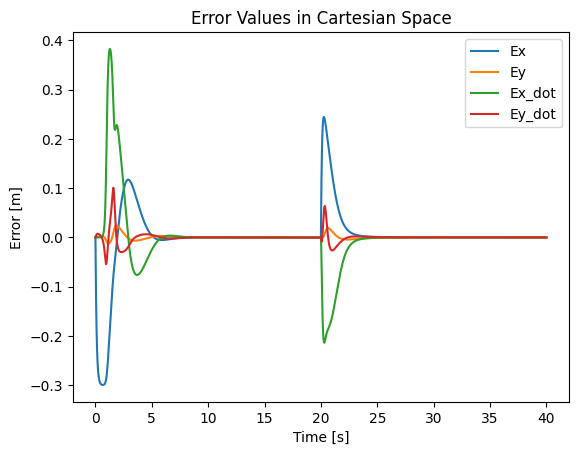

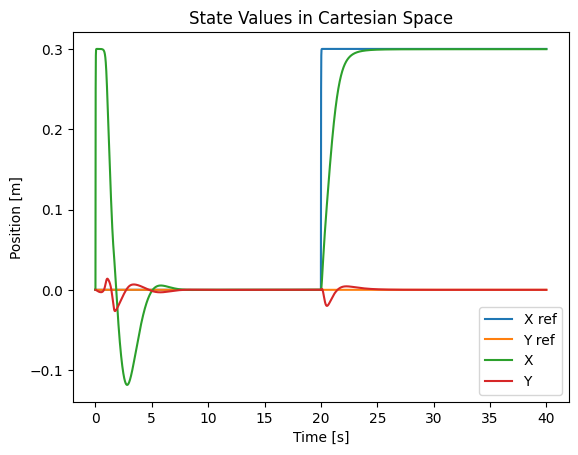

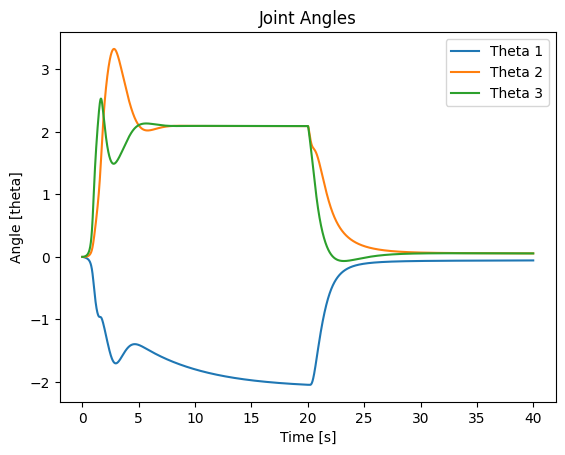

In [254]:
t = sim.trange()
ref_signal = sim.data[reference_probe]
error_signal = sim.data[error_probe]
state_signal = -sim.data[state_probe]
joint_signal = sim.data[joint_probe]
#plt.plot(t,ref_signal)
plt.figure()
plt.title("Error Values in Cartesian Space")
plt.plot(t,error_signal)
plt.xlabel('Time [s]')
plt.ylabel('Error [m]')
plt.legend(['Ex','Ey','Ex_dot','Ey_dot'])
plt.savefig('SSP_basis_operational_space')

plt.figure()
plt.title("State Values in Cartesian Space")
plt.plot(t,ref_signal[:,0:2])
plt.plot(t,state_signal[:,0:2])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['X ref','Y ref','X','Y'])
plt.savefig('SSP_basis_error')

plt.figure()
plt.plot(t,joint_signal[:,0:3])
plt.title("Joint Angles")
plt.xlabel('Time [s]')
plt.ylabel('Angle [theta]')
plt.legend(['Theta 1','Theta 2','Theta 3'])

plt.savefig('SSP_basis_joint_space')